In [3]:
import os
import sys

os.environ['CUDA_VISIBLE_DEVICES']=''

import time
import tqdm
import glob
import yaml
import keras
import emcee
import astropy
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.backend as K
import astropy.units as u
import astropy.constants as c
import matplotlib.pyplot as plt
from keras.optimizers import adam
from matplotlib.lines import Line2D
from scipy.optimize import minimize
from scipy.signal import savgol_filter
from keras.models import Sequential,Model
from keras.callbacks import EarlyStopping
import keras.backend.tensorflow_backend as KTF
from dust_extinction.averages import GCC09_MWAvg
from scipy.ndimage.filters import gaussian_filter1d
from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d,UnivariateSpline
from dust_extinction.parameter_averages import CCM89,F99
from keras.callbacks import TerminateOnNaN,EarlyStopping,ModelCheckpoint
from keras.layers import Dense,Dropout,LocallyConnected1D,AveragePooling1D,Flatten,Layer,Reshape
from keras.layers import Input,Conv1D,MaxPooling1D,BatchNormalization,Activation,Add,UpSampling1D,Concatenate

from GaussianNetworkKit import *


In [4]:
wave=np.genfromtxt('Prim.ascii')[:,0]
dm15List=pd.read_csv('dm15WithDens.csv',index_col=0)

In [5]:
def Normalizer(spec,shortwave=6500,longwave=7500):
    small=np.argmin(abs(spec[:,0]-shortwave))
    long=np.argmin(abs(spec[:,0]-longwave))
    if small<long:spec[:,1]=spec[:,1]/np.average(spec[small:long,1])
    if small>long:spec[:,1]=spec[:,1]/np.average(spec[long:small,1])
    return spec
def ChainCal(t):
    Co56H=77.233
    Ni56H=6.075
    NiMass=2**(-t/Ni56H)
    A=-np.log(2**(-1/Ni56H))/(np.log(2**(-1/Ni56H))+np.log(2**(-1/Co56H)))
    B=-A
    CoMass=A*2**(-t/Ni56H)+B*2**(-t/Co56H)
    FeMass=1-CoMass-NiMass
    return NiMass,CoMass,FeMass
def windowSpec(spec):
    spFunc=interp1d(spec[:,0],spec[:,1],fill_value=np.nan,bounds_error=False)
    smFlux=spFunc(wave)
    smFlux=smFlux/np.nanmean(smFlux)
    smFlux[np.isnan(smFlux)]=-1
    return np.array([wave,smFlux]).T
def CrossCoeff(y1,y2):
    return (np.mean(y1*y2)-np.mean(y1)*np.mean(y2))/np.std(y1)/np.std(y2)

In [6]:
def MinMaxSpec(flux,waveInit=750):# or 885
    breaker=False
    flux=savgol_filter(flux,13,1)
    for j in range(100):
        for k in [-1,1]:
            cenPix=waveInit+j*k
            if np.min(flux[cenPix-4:cenPix+4])==flux[cenPix]:
                breaker=True
                break
        if breaker==True:break
    
    minInde=cenPix
    minWave=wave[minInde]
    minFlux=flux[minInde]
    
    for j in range(minInde-1,0,-1):
        if flux[j]<=minFlux:break
    rightWidth=wave[j]-minWave
    for j in range(minInde+2,len(wave)):
        if flux[j]<=minFlux:break
    leftWidth=wave[j]-minWave
    for j in range(minInde-1,0,-1):
        if np.max(flux[j-8:j+8])==flux[j]:break
    rightMaxWave=wave[j]
    rightMaxFlux=flux[j]
    for j in range(minInde+2,len(wave)):
        if np.max(flux[j-8:j+8])==flux[j]:break
    leftMaxWave=wave[j]
    leftMaxFlux=flux[j]
    return minFlux,minWave,leftMaxFlux,leftMaxWave,rightMaxFlux,rightMaxWave,leftWidth,rightWidth
def SpecGausSamp(spec):
    mask=(spec[:,0]<4200)&(spec[:,0]>3800)
    spSma=spec[mask]
    def gausFunc(x,A,mu,sig):
        return A/sig/(2*np.pi)**0.5*np.exp(-0.5*(x-mu)**2/sig**2)
    def TwoGaus(params):
        returner=np.ones(len(spSma[:,1]))*params[0]+(spSma[:,0]-4000)*params[1]/1000
        gausCompNum=int((len(params)-2)/3)
        for i in range(gausCompNum):
            returner=returner+gausFunc(spSma[:,0],params[i*3+2],params[i*3+3],params[i*3+4],)
        return returner
    def Like(params):
        mdVals=TwoGaus(params)
        obsVal=spSma[:,1]
        return np.sum((mdVals-obsVal)**2/mdVals)
    
    result=minimize(Like,x0=[1,1,100,3900,100,100,4000,100,100,4100,120])
    parGood=result.x
    def LnLike(params,likeGood=Like(parGood),parGood=parGood):
        likeHere=Like(params)
        parDif=np.abs(np.array(params)-np.array(parGood))/np.array(parGood)
        if likeHere/likeGood-1>(len(spSma)*2)**0.5:return -np.inf
        if np.max(parDif)>1:return -np.inf
        return -likeHere
    ndim=11
    nwalkers=2*ndim
    pos=np.array(parGood)+np.random.randn(nwalkers,ndim)*0.0001
    sampler=emcee.EnsembleSampler(nwalkers,ndim,LnLike)
    sampler.run_mcmc(pos,200,progress=True)
    flat_sample=sampler.get_chain(discard=150,thin=1,flat=True)
    fluxList=np.ones([len(flat_sample),2000])*-1
    for i in range(len(flat_sample)):
        param=flat_sample[i]
        if TwoGaus(param).min()<0:continue
        fluxList[i,mask]=TwoGaus(param)
    return fluxList

In [7]:
def MinMaxSpecBlue(flux):
    flux=savgol_filter(flux,11,1)
    waveInit=915
    breaker=False
    for j in range(100):
        for k in [-1,1]:
            cenPix=waveInit+j*k
            if np.min(flux[cenPix-5:cenPix+5])==flux[cenPix]:
                breaker=True
                break
        if breaker==True:break
    
    minInde=cenPix
    minWave=wave[minInde]
    minFlux=flux[minInde]
    
    for j in range(minInde-1,0,-1):
        if flux[j]<=minFlux:break
    rightWidth=wave[j]-minWave
    for j in range(minInde+2,len(wave)):
        if flux[j]<=minFlux:break
    leftWidth=wave[j]-minWave
    for j in range(minInde-1,0,-1):
        if np.max(flux[j-8:j+8])==flux[j]:break
    rightMaxWave=wave[j]
    rightMaxFlux=flux[j]
    for j in range(minInde+2,len(wave)):
        if np.max(flux[j-8:j+8])==flux[j]:break
    leftMaxWave=wave[j]
    leftMaxFlux=flux[j]
    return minFlux,minWave,leftMaxFlux,leftMaxWave,rightMaxFlux,rightMaxWave,leftWidth,rightWidth

In [8]:
def specListMaker(starTableDir,redshift,extMW=0,extHost=0,telNameGetter=False):
    starTable=pd.read_csv(starTableDir+'starTable.csv')#'../ObserveSpectra/GoodSpec/SN2011fe/starTable.csv'
    X_snemo=[]
    timeCollect=[]
    telNameList=[]
    for i in range(len(starTable)):
        if starTable['Phase'][i]>20 or starTable['Phase'][i]<-10:continue
        fileName=starTable['Ascii file'].iloc[i]
        fileName=glob.glob(starTableDir+fileName.split('.dat')[0]+'*')[0]
        spec=np.genfromtxt(fileName)
        spec[:,1]=spec[:,1]/GCC09_MWAvg().extinguish(spec[:,0]*u.Angstrom,Ebv=extMW)
        spec[:,0]=spec[:,0]/(1+redshift)
        spec[:,1]=spec[:,1]/F99().extinguish(spec[:,0]*u.Angstrom,Ebv=extHost)
        spec=Normalizer(spec)
        spResa=windowSpec(spec)
        if np.max(spResa[:,1])>20:continue
        X_snemo.append(spResa[:,1].reshape([2000,1]))
        timeCollect.append(starTable['Phase'][i])
        if telNameGetter:
            telNameList.append(starTable['Tel'][i])
    X_snemo=np.array(X_snemo)
    timeCollect=np.array(timeCollect)+19
    if telNameGetter:
        return X_snemo,timeCollect,telNameList
    else:
        return X_snemo,timeCollect

In [9]:
X_train=np.load('DataSet/110KRun/X_train.npy')
X_test=np.load('DataSet/110KRun/X_test.npy')
Y_train=np.load('DataSet/110KRun/Y_train.npy')
Y_test=np.load('DataSet/110KRun/Y_test.npy')
Yaux_train=np.load('DataSet/110KRun/Yaux_train.npy')
Yaux_test=np.load('DataSet/110KRun/Yaux_test.npy')
YauxNorm=np.load('DataSet/110KRun/YauxNorm.npy')

In [10]:
def MRNNSoftMaxESMake(CellNumber=7,outter=0,X_train=X_train,X_test=X_test,Y_train=Y_train,Y_test=Y_test,Yaux_train=Yaux_train,Yaux_test=Yaux_test):
    INput=Input(shape=(X_train.shape[1],1,))
    conv1=Conv1D(8,15,strides=2,padding='same')(INput)
    conv1=Conv1D(16,3,strides=1,padding='same')(conv1)
    batc1=BatchNormalization()(conv1)
    acti1=Activation('selu')(batc1)
    pool1=MaxPooling1D(2)(acti1)
    
    conv2=Conv1D(8,1)(pool1)
    batc2=BatchNormalization()(conv2)
    acti2=Activation('selu')(batc2)
    conv3=Conv1D(16,3,padding='same')(acti2)
    
    adds=[pool1]
    
    addi=Add()(adds+[conv3])
    adds.append(addi)
    
    for i in range(CellNumber):
        conv2=Conv1D(8,1)(addi)
        batc2=BatchNormalization()(conv2)
        acti2=Activation('selu')(batc2)
        conv3=Conv1D(16,3,padding='same')(acti2)
        addi=Add()(adds+[conv3])
        adds.append(addi)
    
    batc2=BatchNormalization()(addi)
    
    flat1=keras.layers.Flatten()(batc2)
    drop1=Dropout(0.2)(flat1)
    dens1=Dense(256,activation='selu')(drop1)
    
    INput2=Input(shape=(3,))
    dens2=Dense(6,activation='selu')(INput2)
    dens2=Dense(9,activation='selu')(dens2)
    conc1=Concatenate()([INput2,dens2])
    dens2=Dense(21,activation='selu')(conc1)
    conc1=Concatenate()([INput2,dens2])
    dens2=Dense(45,activation='selu')(conc1)
    conc1=Concatenate()([INput2,dens2])
    
    conc2=Concatenate()([conc1,dens1])
    dens3=Dense(384,activation='selu')(conc2)
    drop2=Dropout(0.2)(dens3)
    
    dens3=Dense(256,activation='selu')(drop2)
    dens3=Dense(256,activation='selu')(dens3)
    dens3=Dense(256,activation='selu')(dens3)
    dens3=Dense(256,activation='selu')(dens3)
    
    if outter==6:mu,sig=GaussianLayer(2,name='ld_out')(dens3)
    else:mu,sig=GaussianLayer(30,hardMax=False,name='zone_'+str(outter)+'_out')(dens3)
    model=Model(inputs=[INput,INput2],outputs=mu)
    print(model.summary())
    opt=keras.optimizers.adam(lr=0.00003,decay=1e-6)
    model.compile(optimizer=opt,loss=custom_loss(sig))
    return model

In [11]:
intermediateModels=[]
for outter in range(7):
    valiLossList=[]
    for mdInd in range(10):
        try:
            his2=pd.read_csv('Metric/110KLogML/ES_'+str(outter)+'_'+str(mdInd)+'_His2.csv')
            valiLoss=his2['val_loss'].iloc[-1]
            if np.isnan(valiLoss):valiLoss=np.inf
        except:valiLoss=np.inf
        valiLossList.append(valiLoss)
    mdIndChos=np.argmin(valiLossList)
    model=MRNNSoftMaxESMake(outter=outter)
    model.load_weights('MdSaver/110KLogML/Model_'+str(outter)+'_'+str(mdIndChos)+'.hdf')
    if outter==6:
        outLayerName='ld_out'
    else:outLayerName='zone_'+str(outter)+'_out'
    intermediateModels.append(K.function(inputs=[model.input[0],model.input[1]],outputs=model.get_layer(outLayerName).output))

W0219 13:34:41.967486 47687773032064 deprecation_wrapper.py:119] From /scratch/user/chenxingzhuo/.conda/envs/keras/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0219 13:34:41.993883 47687773032064 deprecation_wrapper.py:119] From /scratch/user/chenxingzhuo/.conda/envs/keras/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0219 13:34:42.000730 47687773032064 deprecation_wrapper.py:119] From /scratch/user/chenxingzhuo/.conda/envs/keras/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0219 13:34:42.138779 47687773032064 deprecation_wrapper.py:119] From /scratch/user/chenxingzhuo/.conda/envs/keras/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: T

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2000, 1)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1000, 8)      128         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 1000, 16)     400         conv1d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 1000, 16)     64          conv1d_2[0][0]                   
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 2000, 1)      0                                            
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 1000, 8)      128         input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_20 (Conv1D)              (None, 1000, 16)     400         conv1d_19[0][0]                  
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 1000, 16)     64          conv1d_20[0][0]                  
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 2000, 1)      0                                            
__________________________________________________________________________________________________
conv1d_37 (Conv1D)              (None, 1000, 8)      128         input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_38 (Conv1D)              (None, 1000, 16)     400         conv1d_37[0][0]                  
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 1000, 16)     64          conv1d_38[0][0]                  
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 2000, 1)      0                                            
__________________________________________________________________________________________________
conv1d_55 (Conv1D)              (None, 1000, 8)      128         input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_56 (Conv1D)              (None, 1000, 16)     400         conv1d_55[0][0]                  
__________________________________________________________________________________________________
batch_normalization_31 (BatchNo (None, 1000, 16)     64          conv1d_56[0][0]                  
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 2000, 1)      0                                            
__________________________________________________________________________________________________
conv1d_73 (Conv1D)              (None, 1000, 8)      128         input_9[0][0]                    
__________________________________________________________________________________________________
conv1d_74 (Conv1D)              (None, 1000, 16)     400         conv1d_73[0][0]                  
__________________________________________________________________________________________________
batch_normalization_41 (BatchNo (None, 1000, 16)     64          conv1d_74[0][0]                  
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 2000, 1)      0                                            
__________________________________________________________________________________________________
conv1d_91 (Conv1D)              (None, 1000, 8)      128         input_11[0][0]                   
__________________________________________________________________________________________________
conv1d_92 (Conv1D)              (None, 1000, 16)     400         conv1d_91[0][0]                  
__________________________________________________________________________________________________
batch_normalization_51 (BatchNo (None, 1000, 16)     64          conv1d_92[0][0]                  
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 2000, 1)      0                                            
__________________________________________________________________________________________________
conv1d_109 (Conv1D)             (None, 1000, 8)      128         input_13[0][0]                   
__________________________________________________________________________________________________
conv1d_110 (Conv1D)             (None, 1000, 16)     400         conv1d_109[0][0]                 
__________________________________________________________________________________________________
batch_normalization_61 (BatchNo (None, 1000, 16)     64          conv1d_110[0][0]                 
__________________________________________________________________________________________________
activation

In [12]:
def ModelPredictor(modelList,specList,auxInList):
    matExport=np.zeros([len(specList),6,30])
    errExport=np.zeros([len(specList),6,30])
    for j in range(6):
        mu,sigma=modelList[j]([specList,auxInList])
        matExport[:,j,:]=mu
        errExport[:,j,:]=sigma**0.5
    j=6
    mu,sigma=modelList[j]([specList,auxInList])
    sigma=sigma**0.5
    mu[:,0]=mu[:,0]*YauxNorm[1,0]+YauxNorm[0,0]
    mu[:,1]=mu[:,1]*YauxNorm[1,2]+YauxNorm[0,2]
    sigma[:,0]=sigma[:,0]*YauxNorm[1,0]
    sigma[:,1]=sigma[:,1]*YauxNorm[1,2]
    return matExport,errExport,mu,sigma

In [13]:
XspecList,timeList,snNameList,dm15ChosL,dm15ErrL=[],[],[],[],[]
for i in range(len(dm15List)):
    snName=dm15List['ObjName'].iloc[i]
    redshift=dm15List['Redshift'].iloc[i]
    if os.path.exists('../ObserveSpectra/ObserveSpec3No2/'+snName+'/starTable.csv')==False:continue
    X_snemo,timeCollect=specListMaker('../ObserveSpectra/ObserveSpec3No2/'+snName+'/',redshift,extHost=dm15List['EBVhost'].iloc[i],extMW=dm15List['EBVmw'].iloc[i])
    if len(X_snemo)==0:continue
    timeList.append(timeCollect)
    dm15ChosL.append(dm15List['DM15'].iloc[i])
    dm15ErrL.append(dm15List['DM15err'].iloc[i])
    snNameList.append(dm15List['ObjName'].iloc[i])
    XspecList.append(X_snemo)

In [17]:
dm15List

Unnamed: 0.1   ObjName  Redshift     DM15  DM15err       Subtype     EBV  \
0               0  SN2000cw  0.030100  1.22000    0.040       Ia-norm  0.0613   
1               1  SN2006gr  0.034597  0.81000    0.070       Ia-norm  0.0727   
2               2  SN1999dq  0.014327  0.86000    0.040  Ia-99aa-like  0.0936   
3               3  SN2004gs  0.027425  1.41000    0.110       Ia-norm  0.0257   
4               4  SN2001cp  0.022402  0.88000    0.030       Ia-norm  0.1332   
..            ...       ...       ...      ...      ...           ...     ...   
342           342  SN2006py  0.057900  1.14786    0.074       Ia-norm  0.0518   
343           343   SN2007S  0.013900  0.94000    0.030        Ia-91T  0.0224   
344           344   SN2007O  0.036212  1.13614    0.070       Ia-norm  0.0182   
345           345  SN2012ht  0.003559  1.39000    0.000       Ia-norm  0.0252   
346           346  SN2007al  0.012175  1.89000    0.050       Ia-91bg  0.0360   

     EBVhost   EBVmw  pivot  slope  
0      0.000  0.0613    1.3    1.1  
1      0.265  0.0000    1.2    0.7  
2      0.290  0.0000    1.0    1.3  
3      0.000  0.0257    1.0    1.2  
4      0.000  0.1332    0.9    1.5  
..       ...     ...    ...    ...  
342    0.000  0.0518    0.3    0.5  
343    0.518  0.0000    1.4    0.9  
344    0.040  0.0000    NaN    NaN  
345    0.000  0.0252    1.4    1.0  
346    0.172  0.0000    1.3    1.1  

[347 rows x 11 columns]

In [14]:
intMdl=intermediateModels[3]
timeHigh=np.linspace(10,40,num=2000)
NiA,CoA,FeA=ChainCal(timeHigh)

In [15]:
elemList=[]
errList=[]
for i in range(len(XspecList)):
    X_snemo=XspecList[i].copy()
    timeCollect=timeList[i].copy()
    pivot=dm15List[dm15List['ObjName']==snNameList[i]]['pivot'].iloc[0]
    slope=dm15List[dm15List['ObjName']==snNameList[i]]['slope'].iloc[0]
    if np.isnan(pivot):pivot=1
    if np.isnan(slope):slope=1
    timeNorm=(timeCollect-YauxNorm[0,1])/YauxNorm[1,1]
    timeNorm=timeNorm.reshape([-1,1])
    dens1Norm=(np.ones([len(X_snemo),1])*pivot-YauxNorm[0,3])/YauxNorm[1,3]
    dens2Norm=(np.ones([len(X_snemo),1])*slope-YauxNorm[0,4])/YauxNorm[1,4]
    auxIn=np.hstack([timeNorm,dens1Norm,dens2Norm])
    mu,sigma=intMdl([X_snemo,auxIn])
    elemList.append(mu)
    errList.append(sigma**0.5)

In [47]:
yout=[]
yerrout=[]
timeOut=[]
xout=[]
xerrout=[]
typeList=[]
nameSelList=[]

timeMin=9
timeMax=12

for i in range(len(elemList)):
    timeCol=timeList[i]
    mask=(timeCol>timeMin)&(timeCol<=timeMax)
    timeCol=timeCol[mask]
    if len(timeCol)==0:continue
    timeOut.append(timeCol)
    yplot=elemList[i][mask,28-1]
    yerrplot=errList[i][mask,28-1]
    yout.append(yplot)
    xout.append(np.ones(len(yplot))*dm15ChosL[i])
    
    typeList.append(dm15List[dm15List['ObjName']==snNameList[i]]['Subtype'].iloc[0])
    yerrout.append(yerrplot)
    xerrout.append(np.ones(len(yplot))*dm15ErrL[i])
    nameSelList.append(snNameList[i])

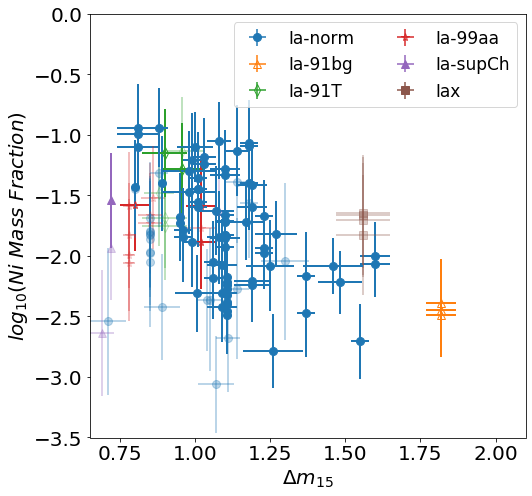

In [48]:
cList=['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','e377c2']
for i in range(len(timeOut)):
    xplot=xout[i]
    yplot=yout[i]
    xerrplot=xerrout[i]
    yerrplot=yerrout[i]
    if typeList[i]=='Ia-norm':
        color=cList[0]
        fmtDef='o'
        fmtFil='full'
    if typeList[i]=='Ia-91bg':
        color=cList[1]
        fmtDef='^'
        fmtFil='none'
    if typeList[i]=='Ia-91T':
        color=cList[2]
        fmtDef='d'
        fmtFil='none'
    if typeList[i]=='Ia-99aa-like':
        color=cList[3]
        fmtDef='*'
        fmtFil='none'
    if typeList[i]=='Ia-supCh':
        color=cList[4]
        fmtDef='^'
        fmtFil='full'
    if typeList[i]=='Iax':
        color=cList[5]
        fmtDef='s'
        fmtFil='full'
    mask=(yerrplot<0.4)
    plt.errorbar(xplot[mask],yplot[mask],yerr=yerrplot[mask],xerr=xerrplot[mask],fmt=fmtDef,c=color,alpha=1,ms=8,linewidth=2,fillstyle=fmtFil)
    mask=(mask==False)
    plt.errorbar(xplot[mask],yplot[mask],yerr=yerrplot[mask],xerr=xerrplot[mask],fmt=fmtDef,c=color,alpha=0.3,ms=8,linewidth=2,fillstyle=fmtFil)
plt.gcf().set_size_inches(7.5,7)
plt.ylim(-3.5,0)
plt.xlim(0.65,2.1)

plt.errorbar([],[],[],[],label='Ia-norm', fmt='o',fillstyle='full',color=cList[0],ms=8)
plt.errorbar([],[],[],[],label='Ia-91bg', fmt='^',fillstyle='none',color=cList[1],ms=8)
plt.errorbar([],[],[],[],label='Ia-91T',  fmt='d',fillstyle='none',color=cList[2],ms=8)
plt.errorbar([],[],[],[],label='Ia-99aa', fmt='*',fillstyle='none',color=cList[3],ms=8)
plt.errorbar([],[],[],[],label='Ia-supCh',fmt='^',fillstyle='full',color=cList[4],ms=8)
plt.errorbar([],[],[],[],label='Iax',     fmt='s',fillstyle='full',color=cList[5],ms=8)
plt.legend(fontsize=17,ncol=2)
plt.xlabel(r'$\Delta m_{15}$',fontsize=20)
plt.ylabel(r'$log_{10}(Ni\ Mass\ Fraction)$',fontsize=20)
plt.tick_params(labelsize=20)
plt.tight_layout()
plt.savefig('plotout/paperPlot/dm15Ni3Phase1.png')

In [16]:
yout=[]
yerrout=[]
timeOut=[]
xout=[]
xerrout=[]
typeList=[]
nameSelList=[]

timeMin=12
timeMax=15

for i in range(len(elemList)):
    timeCol=timeList[i]
    mask=(timeCol>timeMin)&(timeCol<=timeMax)
    timeCol=timeCol[mask]
    if len(timeCol)==0:continue
    timeOut.append(timeCol)
    yplot=elemList[i][mask,28-1]
    yerrplot=errList[i][mask,28-1]
    yout.append(yplot)
    xout.append(np.ones(len(yplot))*dm15ChosL[i])
    
    typeList.append(dm15List[dm15List['ObjName']==snNameList[i]]['Subtype'].iloc[0])
    yerrout.append(yerrplot)
    xerrout.append(np.ones(len(yplot))*dm15ErrL[i])
    nameSelList.append(snNameList[i])

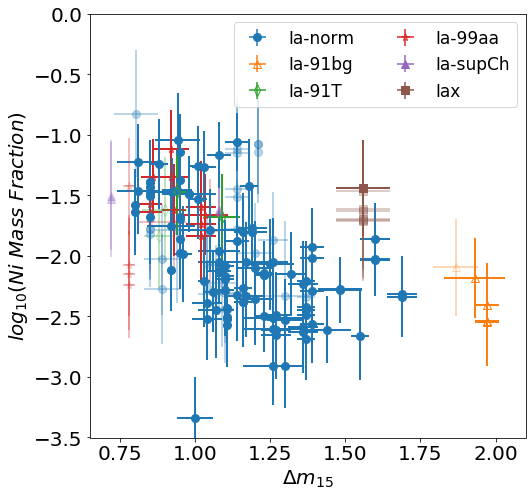

In [17]:
cList=['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','e377c2']
for i in range(len(timeOut)):
    xplot=xout[i]
    yplot=yout[i]
    xerrplot=xerrout[i]
    yerrplot=yerrout[i]
    if typeList[i]=='Ia-norm':
        color=cList[0]
        fmtDef='o'
        fmtFil='full'
    if typeList[i]=='Ia-91bg':
        color=cList[1]
        fmtDef='^'
        fmtFil='none'
    if typeList[i]=='Ia-91T':
        color=cList[2]
        fmtDef='d'
        fmtFil='none'
    if typeList[i]=='Ia-99aa-like':
        color=cList[3]
        fmtDef='*'
        fmtFil='none'
    if typeList[i]=='Ia-supCh':
        color=cList[4]
        fmtDef='^'
        fmtFil='full'
    if typeList[i]=='Iax':
        color=cList[5]
        fmtDef='s'
        fmtFil='full'
    mask=(yerrplot<0.4)
    plt.errorbar(xplot[mask],yplot[mask],yerr=yerrplot[mask],xerr=xerrplot[mask],fmt=fmtDef,c=color,alpha=1,ms=8,linewidth=2,fillstyle=fmtFil)
    mask=(mask==False)
    plt.errorbar(xplot[mask],yplot[mask],yerr=yerrplot[mask],xerr=xerrplot[mask],fmt=fmtDef,c=color,alpha=0.3,ms=8,linewidth=2,fillstyle=fmtFil)
plt.gcf().set_size_inches(7.5,7)
plt.ylim(-3.5,0)
plt.xlim(0.65,2.1)

plt.errorbar([],[],[],[],label='Ia-norm', fmt='o',fillstyle='full',color=cList[0],ms=8)
plt.errorbar([],[],[],[],label='Ia-91bg', fmt='^',fillstyle='none',color=cList[1],ms=8)
plt.errorbar([],[],[],[],label='Ia-91T',  fmt='d',fillstyle='none',color=cList[2],ms=8)
plt.errorbar([],[],[],[],label='Ia-99aa', fmt='*',fillstyle='none',color=cList[3],ms=8)
plt.errorbar([],[],[],[],label='Ia-supCh',fmt='^',fillstyle='full',color=cList[4],ms=8)
plt.errorbar([],[],[],[],label='Iax',     fmt='s',fillstyle='full',color=cList[5],ms=8)
plt.legend(fontsize=17,ncol=2)
plt.xlabel(r'$\Delta m_{15}$',fontsize=20)
plt.ylabel(r'$log_{10}(Ni\ Mass\ Fraction)$',fontsize=20)
plt.tick_params(labelsize=20)
plt.tight_layout()
plt.savefig('plotout/paperPlot/dm15Ni3Phase2.png')

In [18]:
yout=[]
yerrout=[]
timeOut=[]
xout=[]
xerrout=[]
typeList=[]
nameSelList=[]

timeMin=15
timeMax=18

for i in range(len(elemList)):
    timeCol=timeList[i]
    mask=(timeCol>timeMin)&(timeCol<=timeMax)
    timeCol=timeCol[mask]
    if len(timeCol)==0:continue
    timeOut.append(timeCol)
    yplot=elemList[i][mask,28-1]
    yerrplot=errList[i][mask,28-1]
    yout.append(yplot)
    xout.append(np.ones(len(yplot))*dm15ChosL[i])
    
    typeList.append(dm15List[dm15List['ObjName']==snNameList[i]]['Subtype'].iloc[0])
    yerrout.append(yerrplot)
    xerrout.append(np.ones(len(yplot))*dm15ErrL[i])
    nameSelList.append(snNameList[i])

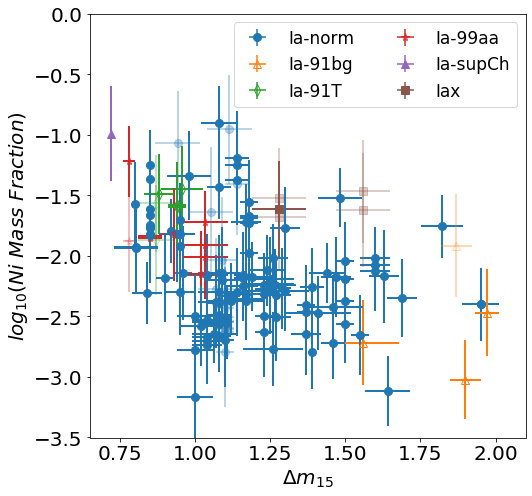

In [19]:
cList=['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','e377c2']
for i in range(len(timeOut)):
    xplot=xout[i]
    yplot=yout[i]
    xerrplot=xerrout[i]
    yerrplot=yerrout[i]
    if typeList[i]=='Ia-norm':
        color=cList[0]
        fmtDef='o'
        fmtFil='full'
    if typeList[i]=='Ia-91bg':
        color=cList[1]
        fmtDef='^'
        fmtFil='none'
    if typeList[i]=='Ia-91T':
        color=cList[2]
        fmtDef='d'
        fmtFil='none'
    if typeList[i]=='Ia-99aa-like':
        color=cList[3]
        fmtDef='*'
        fmtFil='none'
    if typeList[i]=='Ia-supCh':
        color=cList[4]
        fmtDef='^'
        fmtFil='full'
    if typeList[i]=='Iax':
        color=cList[5]
        fmtDef='s'
        fmtFil='full'
    mask=(yerrplot<0.4)
    plt.errorbar(xplot[mask],yplot[mask],yerr=yerrplot[mask],xerr=xerrplot[mask],fmt=fmtDef,c=color,alpha=1,ms=8,linewidth=2,fillstyle=fmtFil)
    mask=(mask==False)
    plt.errorbar(xplot[mask],yplot[mask],yerr=yerrplot[mask],xerr=xerrplot[mask],fmt=fmtDef,c=color,alpha=0.3,ms=8,linewidth=2,fillstyle=fmtFil)
plt.gcf().set_size_inches(7.5,7)
plt.ylim(-3.5,0)
plt.xlim(0.65,2.1)

plt.errorbar([],[],[],[],label='Ia-norm', fmt='o',fillstyle='full',color=cList[0],ms=8)
plt.errorbar([],[],[],[],label='Ia-91bg', fmt='^',fillstyle='none',color=cList[1],ms=8)
plt.errorbar([],[],[],[],label='Ia-91T',  fmt='d',fillstyle='none',color=cList[2],ms=8)
plt.errorbar([],[],[],[],label='Ia-99aa', fmt='*',fillstyle='none',color=cList[3],ms=8)
plt.errorbar([],[],[],[],label='Ia-supCh',fmt='^',fillstyle='full',color=cList[4],ms=8)
plt.errorbar([],[],[],[],label='Iax',     fmt='s',fillstyle='full',color=cList[5],ms=8)
plt.legend(fontsize=17,ncol=2)
plt.xlabel(r'$\Delta m_{15}$',fontsize=20)
plt.ylabel(r'$log_{10}(Ni\ Mass\ Fraction)$',fontsize=20)
plt.tick_params(labelsize=20)
plt.tight_layout()
plt.savefig('plotout/paperPlot/dm15Ni3Phase3.png')

In [41]:
yout=[]
yerrout=[]
timeOut=[]
dm15out=[]
dm15errout=[]
typeList=[]
specList=[]
nameSelList=[]
timeMin=9
timeMax=12

for i in range(len(elemList)):
    timeCol=timeList[i]
    mask=(timeCol>timeMin)&(timeCol<=timeMax)
    timeCol=timeCol[mask]
    if len(timeCol)==0:continue
    timeOut.append(timeCol)
    yplot=elemList[i][mask,28-1]-elemList[i][mask,14-1]
    yerrplot=(errList[i][mask,28-1]**2+errList[i][mask,14-1]**2)**0.5
    yout.append(yplot)
    dm15out.append(np.ones(len(yplot))*dm15ChosL[i])
    specList.append(XspecList[i][mask])
    typeList.append(dm15List[dm15List['ObjName']==snNameList[i]]['Subtype'].iloc[0])
    yerrout.append(yerrplot)
    dm15errout.append(np.ones(len(yplot))*dm15ErrL[i])
    nameSelList.append(snNameList[i])

117

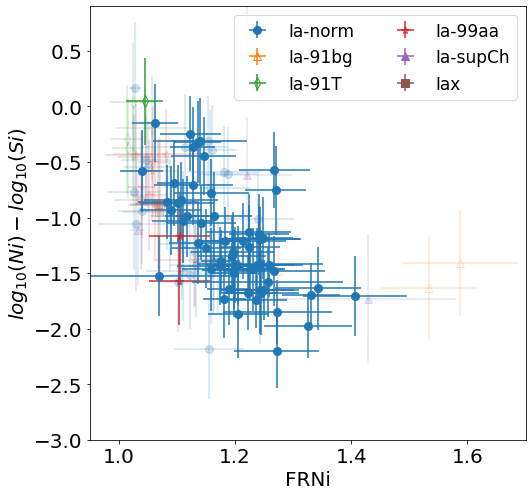

In [42]:
cList=['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','e377c2']
count=0
for i in range(len(yout)):
    yplot=yout[i]
    yerrplot=yerrout[i]
    if typeList[i]=='Ia-norm':
        color=cList[0]
        fmtDef='o'
        fmtFil='full'
    if typeList[i]=='Ia-91bg':
        color=cList[1]
        fmtDef='^'
        fmtFil='none'
    if typeList[i]=='Ia-91T':
        color=cList[2]
        fmtDef='d'
        fmtFil='none'
    if typeList[i]=='Ia-99aa-like':
        color=cList[3]
        fmtDef='*'
        fmtFil='none'
    if typeList[i]=='Ia-supCh':
        color=cList[4]
        fmtDef='^'
        fmtFil='full'
    if typeList[i]=='Iax':
        color=cList[5]
        fmtDef='s'
        fmtFil='full'
    
    for phaseInd in range(len(specList[i])):
        flux=specList[i][phaseInd].flatten()
        minFlux,minWave,leftMaxFlux,leftMaxWave,rightMaxFlux,rightMaxWave,leftWidth,rightWidth=MinMaxSpec(flux)
        if flux[np.argwhere(wave==leftWidth+minWave)[0,0]+1]<0:continue
        minWaveInd=np.argwhere(wave==minWave).flatten()[0]
        minSNR=minFlux/np.std(flux[minWaveInd-10:minWaveInd+10])
        
        leftMaxInd=np.argwhere(wave==leftMaxWave).flatten()[0]
        leftSNR=leftMaxFlux/np.std(flux[leftMaxInd-10:leftMaxInd+10])
        xerrplotOne=leftMaxFlux/minFlux*(1/minSNR**2+1/leftSNR**2)**0.5
        xplotOne=leftMaxFlux/minFlux
        alp=1
        if yerrplot[phaseInd]>0.4 or xplotOne<1:alp=0.2
        if xplotOne>1.7:continue
        #fmtDef=''
        
        plt.errorbar([xplotOne],[yplot[phaseInd]],yerr=[yerrplot[phaseInd]],xerr=[xerrplotOne],alpha=alp,c=color,fmt=fmtDef,fillstyle=fmtFil,ms=8)
        count=count+1
plt.gcf().set_size_inches(7.5,7)
plt.xlim(0.95,1.7)
plt.ylim(-3,0.9)
plt.ylabel(r'$log_{10}(Ni)-log_{10}(Si)$',fontsize=20)
plt.xlabel('FRNi',fontsize=20)

plt.errorbar([],[],[],[],label='Ia-norm', fmt='o',fillstyle='full',color=cList[0],ms=8)
plt.errorbar([],[],[],[],label='Ia-91bg', fmt='^',fillstyle='none',color=cList[1],ms=8)
plt.errorbar([],[],[],[],label='Ia-91T',  fmt='d',fillstyle='none',color=cList[2],ms=8)
plt.errorbar([],[],[],[],label='Ia-99aa', fmt='*',fillstyle='none',color=cList[3],ms=8)
plt.errorbar([],[],[],[],label='Ia-supCh',fmt='^',fillstyle='full',color=cList[4],ms=8)
plt.errorbar([],[],[],[],label='Iax',     fmt='s',fillstyle='full',color=cList[5],ms=8)
plt.legend(fontsize=17,ncol=2)
plt.tick_params(labelsize=20)
plt.tight_layout()
plt.savefig('plotout/paperPlot/FluxRatioNi3mSi3Phase1.png')
count

In [43]:
yout=[]
yerrout=[]
timeOut=[]
dm15out=[]
dm15errout=[]
typeList=[]
specList=[]
nameSelList=[]
timeMin=12
timeMax=15

for i in range(len(elemList)):
    timeCol=timeList[i]
    mask=(timeCol>timeMin)&(timeCol<=timeMax)
    timeCol=timeCol[mask]
    if len(timeCol)==0:continue
    timeOut.append(timeCol)
    yplot=elemList[i][mask,28-1]-elemList[i][mask,14-1]
    yerrplot=(errList[i][mask,28-1]**2+errList[i][mask,14-1]**2)**0.5
    yout.append(yplot)
    dm15out.append(np.ones(len(yplot))*dm15ChosL[i])
    specList.append(XspecList[i][mask])
    typeList.append(dm15List[dm15List['ObjName']==snNameList[i]]['Subtype'].iloc[0])
    yerrout.append(yerrplot)
    dm15errout.append(np.ones(len(yplot))*dm15ErrL[i])
    nameSelList.append(snNameList[i])

160

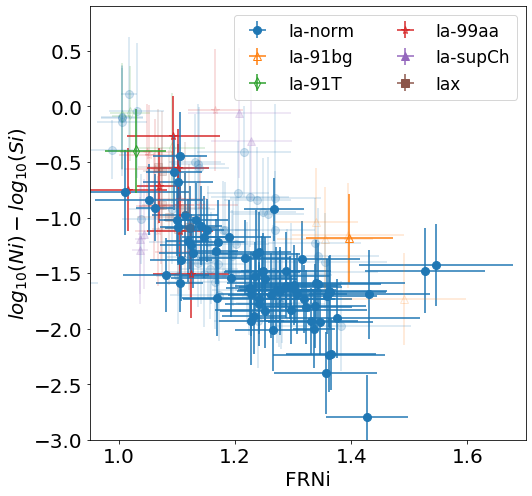

In [44]:
cList=['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','e377c2']
count=0
for i in range(len(yout)):
    yplot=yout[i]
    yerrplot=yerrout[i]
    if typeList[i]=='Ia-norm':
        color=cList[0]
        fmtDef='o'
        fmtFil='full'
    if typeList[i]=='Ia-91bg':
        color=cList[1]
        fmtDef='^'
        fmtFil='none'
    if typeList[i]=='Ia-91T':
        color=cList[2]
        fmtDef='d'
        fmtFil='none'
    if typeList[i]=='Ia-99aa-like':
        color=cList[3]
        fmtDef='*'
        fmtFil='none'
    if typeList[i]=='Ia-supCh':
        color=cList[4]
        fmtDef='^'
        fmtFil='full'
    if typeList[i]=='Iax':
        color=cList[5]
        fmtDef='s'
        fmtFil='full'
    
    for phaseInd in range(len(specList[i])):
        flux=specList[i][phaseInd].flatten()
        minFlux,minWave,leftMaxFlux,leftMaxWave,rightMaxFlux,rightMaxWave,leftWidth,rightWidth=MinMaxSpec(flux)
        if flux[np.argwhere(wave==leftWidth+minWave)[0,0]+1]<0:continue
        minWaveInd=np.argwhere(wave==minWave).flatten()[0]
        minSNR=minFlux/np.std(flux[minWaveInd-10:minWaveInd+10])
        
        leftMaxInd=np.argwhere(wave==leftMaxWave).flatten()[0]
        leftSNR=leftMaxFlux/np.std(flux[leftMaxInd-10:leftMaxInd+10])
        xerrplotOne=leftMaxFlux/minFlux*(1/minSNR**2+1/leftSNR**2)**0.5
        xplotOne=leftMaxFlux/minFlux
        alp=1
        if yerrplot[phaseInd]>0.4 or xplotOne<1:alp=0.2
        if xplotOne>1.7:continue
        #fmtDef=''
        
        plt.errorbar([xplotOne],[yplot[phaseInd]],yerr=[yerrplot[phaseInd]],xerr=[xerrplotOne],alpha=alp,c=color,fmt=fmtDef,fillstyle=fmtFil,ms=8)
        count=count+1
plt.gcf().set_size_inches(7.5,7)
plt.xlim(0.95,1.7)
plt.ylim(-3,0.9)
plt.ylabel(r'$log_{10}(Ni)-log_{10}(Si)$',fontsize=20)
plt.xlabel('FRNi',fontsize=20)

plt.errorbar([],[],[],[],label='Ia-norm', fmt='o',fillstyle='full',color=cList[0],ms=8)
plt.errorbar([],[],[],[],label='Ia-91bg', fmt='^',fillstyle='none',color=cList[1],ms=8)
plt.errorbar([],[],[],[],label='Ia-91T',  fmt='d',fillstyle='none',color=cList[2],ms=8)
plt.errorbar([],[],[],[],label='Ia-99aa', fmt='*',fillstyle='none',color=cList[3],ms=8)
plt.errorbar([],[],[],[],label='Ia-supCh',fmt='^',fillstyle='full',color=cList[4],ms=8)
plt.errorbar([],[],[],[],label='Iax',     fmt='s',fillstyle='full',color=cList[5],ms=8)
plt.legend(fontsize=17,ncol=2)
plt.tick_params(labelsize=20)
plt.tight_layout()
plt.savefig('plotout/paperPlot/FluxRatioNi3mSi3Phase2.png')
count

In [45]:
yout=[]
yerrout=[]
timeOut=[]
dm15out=[]
dm15errout=[]
typeList=[]
specList=[]
nameSelList=[]
timeMin=15
timeMax=18

for i in range(len(elemList)):
    timeCol=timeList[i]
    mask=(timeCol>timeMin)&(timeCol<=timeMax)
    timeCol=timeCol[mask]
    if len(timeCol)==0:continue
    timeOut.append(timeCol)
    yplot=elemList[i][mask,28-1]-elemList[i][mask,14-1]
    yerrplot=(errList[i][mask,28-1]**2+errList[i][mask,14-1]**2)**0.5
    yout.append(yplot)
    dm15out.append(np.ones(len(yplot))*dm15ChosL[i])
    specList.append(XspecList[i][mask])
    typeList.append(dm15List[dm15List['ObjName']==snNameList[i]]['Subtype'].iloc[0])
    yerrout.append(yerrplot)
    dm15errout.append(np.ones(len(yplot))*dm15ErrL[i])
    nameSelList.append(snNameList[i])

149

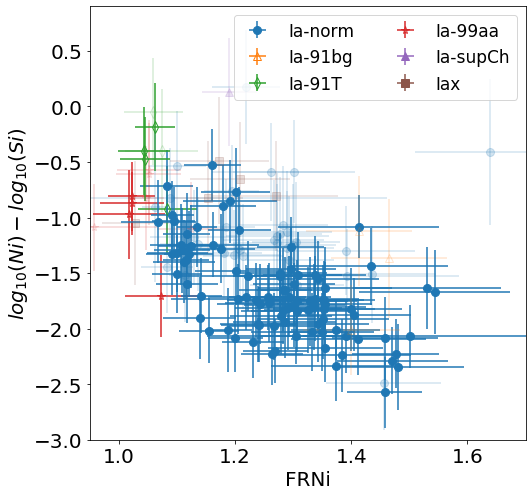

In [46]:
cList=['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','e377c2']
count=0
for i in range(len(yout)):
    yplot=yout[i]
    yerrplot=yerrout[i]
    if typeList[i]=='Ia-norm':
        color=cList[0]
        fmtDef='o'
        fmtFil='full'
    if typeList[i]=='Ia-91bg':
        color=cList[1]
        fmtDef='^'
        fmtFil='none'
    if typeList[i]=='Ia-91T':
        color=cList[2]
        fmtDef='d'
        fmtFil='none'
    if typeList[i]=='Ia-99aa-like':
        color=cList[3]
        fmtDef='*'
        fmtFil='none'
    if typeList[i]=='Ia-supCh':
        color=cList[4]
        fmtDef='^'
        fmtFil='full'
    if typeList[i]=='Iax':
        color=cList[5]
        fmtDef='s'
        fmtFil='full'
    
    for phaseInd in range(len(specList[i])):
        flux=specList[i][phaseInd].flatten()
        minFlux,minWave,leftMaxFlux,leftMaxWave,rightMaxFlux,rightMaxWave,leftWidth,rightWidth=MinMaxSpec(flux)
        if flux[np.argwhere(wave==leftWidth+minWave)[0,0]+1]<0:continue
        minWaveInd=np.argwhere(wave==minWave).flatten()[0]
        minSNR=minFlux/np.std(flux[minWaveInd-10:minWaveInd+10])
        
        leftMaxInd=np.argwhere(wave==leftMaxWave).flatten()[0]
        leftSNR=leftMaxFlux/np.std(flux[leftMaxInd-10:leftMaxInd+10])
        xerrplotOne=leftMaxFlux/minFlux*(1/minSNR**2+1/leftSNR**2)**0.5
        xplotOne=leftMaxFlux/minFlux
        alp=1
        if yerrplot[phaseInd]>0.4 or xplotOne<1:alp=0.2
        if xplotOne>1.7:continue
        #fmtDef=''
        
        plt.errorbar([xplotOne],[yplot[phaseInd]],yerr=[yerrplot[phaseInd]],xerr=[xerrplotOne],alpha=alp,c=color,fmt=fmtDef,fillstyle=fmtFil,ms=8)
        count=count+1
plt.gcf().set_size_inches(7.5,7)
plt.xlim(0.95,1.7)
plt.ylim(-3,0.9)
plt.ylabel(r'$log_{10}(Ni)-log_{10}(Si)$',fontsize=20)
plt.xlabel('FRNi',fontsize=20)

plt.errorbar([],[],[],[],label='Ia-norm', fmt='o',fillstyle='full',color=cList[0],ms=8)
plt.errorbar([],[],[],[],label='Ia-91bg', fmt='^',fillstyle='none',color=cList[1],ms=8)
plt.errorbar([],[],[],[],label='Ia-91T',  fmt='d',fillstyle='none',color=cList[2],ms=8)
plt.errorbar([],[],[],[],label='Ia-99aa', fmt='*',fillstyle='none',color=cList[3],ms=8)
plt.errorbar([],[],[],[],label='Ia-supCh',fmt='^',fillstyle='full',color=cList[4],ms=8)
plt.errorbar([],[],[],[],label='Iax',     fmt='s',fillstyle='full',color=cList[5],ms=8)
plt.legend(fontsize=17,ncol=2)
plt.tick_params(labelsize=20)
plt.tight_layout()
plt.savefig('plotout/paperPlot/FluxRatioNi3mSi3Phase3.png')
count

In [20]:
yout=[]
yerrout=[]
timeOut=[]
dm15out=[]
dm15errout=[]
typeList=[]
specList=[]
nameSelList=[]
timeMin=9
timeMax=12

for i in range(len(elemList)):
    timeCol=timeList[i]
    mask=(timeCol>timeMin)&(timeCol<=timeMax)
    timeCol=timeCol[mask]
    if len(timeCol)==0:continue
    timeOut.append(timeCol)
    yplot=elemList[i][mask,28-1]
    yerrplot=errList[i][mask,28-1]
    yout.append(yplot)
    dm15out.append(np.ones(len(yplot))*dm15ChosL[i])
    specList.append(XspecList[i][mask])
    typeList.append(dm15List[dm15List['ObjName']==snNameList[i]]['Subtype'].iloc[0])
    yerrout.append(yerrplot)
    dm15errout.append(np.ones(len(yplot))*dm15ErrL[i])
    nameSelList.append(snNameList[i])

117

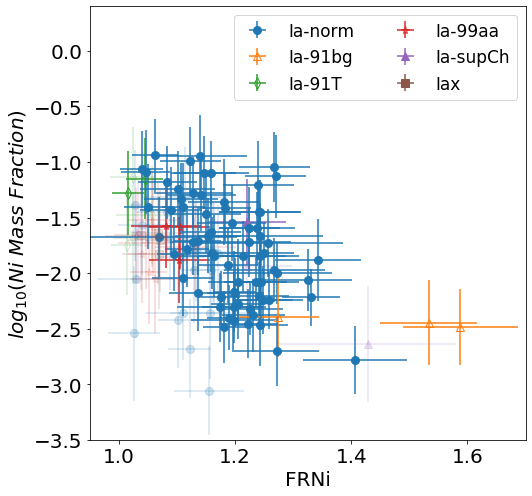

In [21]:
cList=['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','e377c2']
count=0
for i in range(len(yout)):
    yplot=yout[i]
    yerrplot=yerrout[i]
    if typeList[i]=='Ia-norm':
        color=cList[0]
        fmtDef='o'
        fmtFil='full'
    if typeList[i]=='Ia-91bg':
        color=cList[1]
        fmtDef='^'
        fmtFil='none'
    if typeList[i]=='Ia-91T':
        color=cList[2]
        fmtDef='d'
        fmtFil='none'
    if typeList[i]=='Ia-99aa-like':
        color=cList[3]
        fmtDef='*'
        fmtFil='none'
    if typeList[i]=='Ia-supCh':
        color=cList[4]
        fmtDef='^'
        fmtFil='full'
    if typeList[i]=='Iax':
        color=cList[5]
        fmtDef='s'
        fmtFil='full'
    
    for phaseInd in range(len(specList[i])):
        flux=specList[i][phaseInd].flatten()
        minFlux,minWave,leftMaxFlux,leftMaxWave,rightMaxFlux,rightMaxWave,leftWidth,rightWidth=MinMaxSpec(flux)
        if flux[np.argwhere(wave==leftWidth+minWave)[0,0]+1]<0:continue
        minWaveInd=np.argwhere(wave==minWave).flatten()[0]
        minSNR=minFlux/np.std(flux[minWaveInd-10:minWaveInd+10])
        
        leftMaxInd=np.argwhere(wave==leftMaxWave).flatten()[0]
        leftSNR=leftMaxFlux/np.std(flux[leftMaxInd-10:leftMaxInd+10])
        xerrplotOne=leftMaxFlux/minFlux*(1/minSNR**2+1/leftSNR**2)**0.5
        xplotOne=leftMaxFlux/minFlux
        alp=1
        if yerrplot[phaseInd]>0.4 or xplotOne<1:alp=0.2
        if xplotOne>1.7:continue
        #fmtDef=''
        
        plt.errorbar([xplotOne],[yplot[phaseInd]],yerr=[yerrplot[phaseInd]],xerr=[xerrplotOne],alpha=alp,c=color,fmt=fmtDef,fillstyle=fmtFil,ms=8)
        count=count+1
plt.gcf().set_size_inches(7.5,7)
plt.xlim(0.95,1.7)
plt.ylim(-3.5,0.4)
plt.ylabel(r'$log_{10}(Ni\ Mass\ Fraction)$',fontsize=20)
plt.xlabel('FRNi',fontsize=20)

plt.errorbar([],[],[],[],label='Ia-norm', fmt='o',fillstyle='full',color=cList[0],ms=8)
plt.errorbar([],[],[],[],label='Ia-91bg', fmt='^',fillstyle='none',color=cList[1],ms=8)
plt.errorbar([],[],[],[],label='Ia-91T',  fmt='d',fillstyle='none',color=cList[2],ms=8)
plt.errorbar([],[],[],[],label='Ia-99aa', fmt='*',fillstyle='none',color=cList[3],ms=8)
plt.errorbar([],[],[],[],label='Ia-supCh',fmt='^',fillstyle='full',color=cList[4],ms=8)
plt.errorbar([],[],[],[],label='Iax',     fmt='s',fillstyle='full',color=cList[5],ms=8)
plt.legend(fontsize=17,ncol=2)
plt.tick_params(labelsize=20)
plt.tight_layout()
plt.savefig('plotout/paperPlot/FluxRatioNi3Phase1.png')
count

In [22]:
yout=[]
yerrout=[]
timeOut=[]
dm15out=[]
dm15errout=[]
typeList=[]
specList=[]
nameSelList=[]
timeMin=12
timeMax=15

for i in range(len(elemList)):
    timeCol=timeList[i]
    mask=(timeCol>timeMin)&(timeCol<=timeMax)
    timeCol=timeCol[mask]
    if len(timeCol)==0:continue
    timeOut.append(timeCol)
    yplot=elemList[i][mask,28-1]
    yerrplot=errList[i][mask,28-1]
    yout.append(yplot)
    dm15out.append(np.ones(len(yplot))*dm15ChosL[i])
    specList.append(XspecList[i][mask])
    typeList.append(dm15List[dm15List['ObjName']==snNameList[i]]['Subtype'].iloc[0])
    yerrout.append(yerrplot)
    dm15errout.append(np.ones(len(yplot))*dm15ErrL[i])
    nameSelList.append(snNameList[i])

160

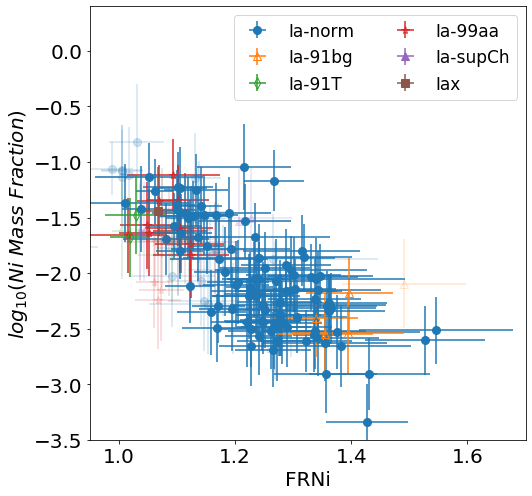

In [23]:
cList=['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','e377c2']
count=0
for i in range(len(yout)):
    yplot=yout[i]
    yerrplot=yerrout[i]
    if typeList[i]=='Ia-norm':
        color=cList[0]
        fmtDef='o'
        fmtFil='full'
    if typeList[i]=='Ia-91bg':
        color=cList[1]
        fmtDef='^'
        fmtFil='none'
    if typeList[i]=='Ia-91T':
        color=cList[2]
        fmtDef='d'
        fmtFil='none'
    if typeList[i]=='Ia-99aa-like':
        color=cList[3]
        fmtDef='*'
        fmtFil='none'
    if typeList[i]=='Ia-supCh':
        color=cList[4]
        fmtDef='^'
        fmtFil='full'
    if typeList[i]=='Iax':
        color=cList[5]
        fmtDef='s'
        fmtFil='full'
    
    for phaseInd in range(len(specList[i])):
        flux=specList[i][phaseInd].flatten()
        minFlux,minWave,leftMaxFlux,leftMaxWave,rightMaxFlux,rightMaxWave,leftWidth,rightWidth=MinMaxSpec(flux)
        if flux[np.argwhere(wave==leftWidth+minWave)[0,0]+1]<0:continue
        minWaveInd=np.argwhere(wave==minWave).flatten()[0]
        minSNR=minFlux/np.std(flux[minWaveInd-10:minWaveInd+10])
        
        leftMaxInd=np.argwhere(wave==leftMaxWave).flatten()[0]
        leftSNR=leftMaxFlux/np.std(flux[leftMaxInd-10:leftMaxInd+10])
        xerrplotOne=leftMaxFlux/minFlux*(1/minSNR**2+1/leftSNR**2)**0.5
        xplotOne=leftMaxFlux/minFlux
        alp=1
        if yerrplot[phaseInd]>0.4 or xplotOne<1:alp=0.2
        if xplotOne>1.7:continue
        #fmtDef=''
        
        plt.errorbar([xplotOne],[yplot[phaseInd]],yerr=[yerrplot[phaseInd]],xerr=[xerrplotOne],alpha=alp,c=color,fmt=fmtDef,fillstyle=fmtFil,ms=8)
        count=count+1
plt.gcf().set_size_inches(7.5,7)
plt.xlim(0.95,1.7)
plt.ylim(-3.5,0.4)
plt.ylabel(r'$log_{10}(Ni\ Mass\ Fraction)$',fontsize=20)
plt.xlabel('FRNi',fontsize=20)

plt.errorbar([],[],[],[],label='Ia-norm', fmt='o',fillstyle='full',color=cList[0],ms=8)
plt.errorbar([],[],[],[],label='Ia-91bg', fmt='^',fillstyle='none',color=cList[1],ms=8)
plt.errorbar([],[],[],[],label='Ia-91T',  fmt='d',fillstyle='none',color=cList[2],ms=8)
plt.errorbar([],[],[],[],label='Ia-99aa', fmt='*',fillstyle='none',color=cList[3],ms=8)
plt.errorbar([],[],[],[],label='Ia-supCh',fmt='^',fillstyle='full',color=cList[4],ms=8)
plt.errorbar([],[],[],[],label='Iax',     fmt='s',fillstyle='full',color=cList[5],ms=8)
plt.legend(fontsize=17,ncol=2)
plt.tick_params(labelsize=20)
plt.tight_layout()
plt.savefig('plotout/paperPlot/FluxRatioNi3Phase2.png')
count

In [24]:
yout=[]
yerrout=[]
timeOut=[]
dm15out=[]
dm15errout=[]
typeList=[]
specList=[]
nameSelList=[]
timeMin=15
timeMax=18

for i in range(len(elemList)):
    timeCol=timeList[i]
    mask=(timeCol>timeMin)&(timeCol<=timeMax)
    timeCol=timeCol[mask]
    if len(timeCol)==0:continue
    timeOut.append(timeCol)
    yplot=elemList[i][mask,28-1]
    yerrplot=errList[i][mask,28-1]
    yout.append(yplot)
    dm15out.append(np.ones(len(yplot))*dm15ChosL[i])
    specList.append(XspecList[i][mask])
    typeList.append(dm15List[dm15List['ObjName']==snNameList[i]]['Subtype'].iloc[0])
    yerrout.append(yerrplot)
    dm15errout.append(np.ones(len(yplot))*dm15ErrL[i])
    nameSelList.append(snNameList[i])

149

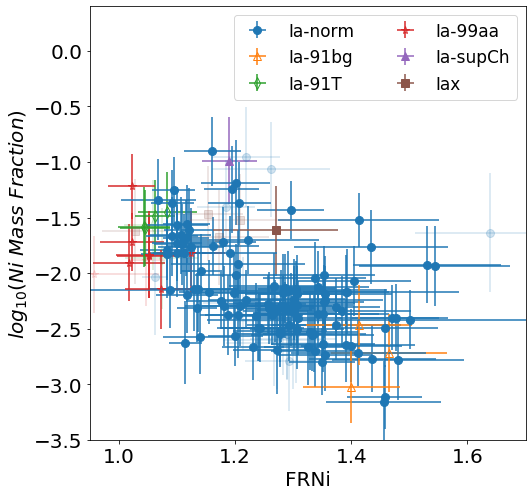

In [25]:
cList=['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','e377c2']
count=0
for i in range(len(yout)):
    yplot=yout[i]
    yerrplot=yerrout[i]
    if typeList[i]=='Ia-norm':
        color=cList[0]
        fmtDef='o'
        fmtFil='full'
    if typeList[i]=='Ia-91bg':
        color=cList[1]
        fmtDef='^'
        fmtFil='none'
    if typeList[i]=='Ia-91T':
        color=cList[2]
        fmtDef='d'
        fmtFil='none'
    if typeList[i]=='Ia-99aa-like':
        color=cList[3]
        fmtDef='*'
        fmtFil='none'
    if typeList[i]=='Ia-supCh':
        color=cList[4]
        fmtDef='^'
        fmtFil='full'
    if typeList[i]=='Iax':
        color=cList[5]
        fmtDef='s'
        fmtFil='full'
    
    for phaseInd in range(len(specList[i])):
        flux=specList[i][phaseInd].flatten()
        minFlux,minWave,leftMaxFlux,leftMaxWave,rightMaxFlux,rightMaxWave,leftWidth,rightWidth=MinMaxSpec(flux)
        if flux[np.argwhere(wave==leftWidth+minWave)[0,0]+1]<0:continue
        minWaveInd=np.argwhere(wave==minWave).flatten()[0]
        minSNR=minFlux/np.std(flux[minWaveInd-10:minWaveInd+10])
        
        leftMaxInd=np.argwhere(wave==leftMaxWave).flatten()[0]
        leftSNR=leftMaxFlux/np.std(flux[leftMaxInd-10:leftMaxInd+10])
        xerrplotOne=leftMaxFlux/minFlux*(1/minSNR**2+1/leftSNR**2)**0.5
        xplotOne=leftMaxFlux/minFlux
        alp=1
        if yerrplot[phaseInd]>0.4 or xplotOne<1:alp=0.2
        if xplotOne>1.7:continue
        #fmtDef=''
        
        plt.errorbar([xplotOne],[yplot[phaseInd]],yerr=[yerrplot[phaseInd]],xerr=[xerrplotOne],alpha=alp,c=color,fmt=fmtDef,fillstyle=fmtFil,ms=8)
        count=count+1
plt.gcf().set_size_inches(7.5,7)
plt.xlim(0.95,1.7)
plt.ylim(-3.5,0.4)
plt.ylabel(r'$log_{10}(Ni\ Mass\ Fraction)$',fontsize=20)
plt.xlabel('FRNi',fontsize=20)

plt.errorbar([],[],[],[],label='Ia-norm', fmt='o',fillstyle='full',color=cList[0],ms=8)
plt.errorbar([],[],[],[],label='Ia-91bg', fmt='^',fillstyle='none',color=cList[1],ms=8)
plt.errorbar([],[],[],[],label='Ia-91T',  fmt='d',fillstyle='none',color=cList[2],ms=8)
plt.errorbar([],[],[],[],label='Ia-99aa', fmt='*',fillstyle='none',color=cList[3],ms=8)
plt.errorbar([],[],[],[],label='Ia-supCh',fmt='^',fillstyle='full',color=cList[4],ms=8)
plt.errorbar([],[],[],[],label='Iax',     fmt='s',fillstyle='full',color=cList[5],ms=8)
plt.legend(fontsize=17,ncol=2)
plt.tick_params(labelsize=20)
plt.tight_layout()
plt.savefig('plotout/paperPlot/FluxRatioNi3Phase3.png')
count

In [108]:
yout=[]
yerrout=[]
timeOut=[]
dm15out=[]
dm15errout=[]
typeList=[]
specList=[]
nameSelList=[]
timeMin=9
timeMax=18

for i in range(len(elemList)):
    timeCol=timeList[i]
    mask=(timeCol>timeMin)&(timeCol<=timeMax)
    timeCol=timeCol[mask]
    if len(timeCol)==0:continue
    timeOut.append(timeCol)
    yplot=elemList[i][mask,28-1]
    yerrplot=errList[i][mask,28-1]
    yout.append(yplot)
    dm15out.append(np.ones(len(yplot))*dm15ChosL[i])
    specList.append(XspecList[i][mask])
    typeList.append(dm15List[dm15List['ObjName']==snNameList[i]]['Subtype'].iloc[0])
    yerrout.append(yerrplot)
    dm15errout.append(np.ones(len(yplot))*dm15ErrL[i])
    nameSelList.append(snNameList[i])

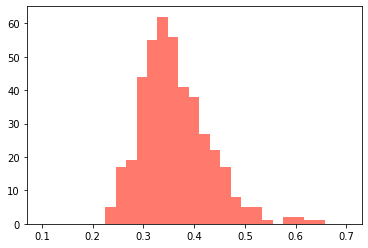

In [117]:
plt.hist(np.concatenate(yerrout),bins=np.linspace(0.1,0.7,num=30),color='xkcd:salmon')
plt.savefig('plotout/hist.png')

In [110]:
len(np.concatenate(yout)),len(yout),np.sum(np.array(typeList)=='Ia-norm')

(428, 127, 100)

In [23]:
(wave[1]-wave[2])/wave[1],(wave[901]-wave[902])/wave[901]

(0.001992031872510003, 0.000713266761768812)

In [24]:
def DER_SNR(flux):
    from numpy import array,where,median,abs 
    flux=array(flux)
    flux=array(flux[where(flux!=0.0)])
    n=len(flux)
    if (n>4):
        signal=median(flux)
        noise=0.6052697*median(abs(2.0*flux[2:n-2]-flux[0:n-4]-flux[4:n]))
        return signal,noise
    else:return 0,100

In [29]:
for i in range(200):
    sig,nor=DER_SNR(X_train[i,:,0])
    print(sig/nor)

28.311262253398464
17.862122584482595
14.878652012390843
13.905228745297082
26.220063052429847
16.67924226149175
20.53934168040128
8.269266743977804
-inf
19.673045004173368
28.51731706053114
9.19294740198917
12.136396549327205
14.183229518485986
13.092395985872324
20.143639924608745
15.909120024955604
16.619755053288767
20.985406256144817
19.054062057526128
13.58165913290708
14.089652069228753
8.656873773266819
-inf
14.077307350195976
23.415385460233747
9.669856459342512
13.849683687534247
-inf
11.345149336348111
13.074542264856358
7.68133523115227
24.420889352249965
16.269164969717696
18.34209054377756
12.499543490893839
9.87911044025463
14.84949295712246
12.737852994212567
16.71962604545069
28.196817053235456
13.018908977613115
15.108486008128153
16.965202761104887
31.798639097982562
15.38474189817583
11.959269034032863
12.177554440116925
22.732383047106406
16.209911428045803
8.422369933877453
19.28326879428503
15.161836246681498
10.002621622493752
7.805503929970409
40.74960538514182

/scratch/user/chenxingzhuo/.conda/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [34]:
freqs=(1/(wave*u.AA/c.c)).to('Hz')

In [35]:
freqs[1:]-freqs[:-1]

<Quantity [5.99584916e+11, 5.99584916e+11, 5.99584916e+11, ...,
           5.99584916e+11, 5.99584916e+11, 5.99584916e+11] Hz>

# $-ln(L)=\Sigma_i ln(\sigma_i)+\frac{1}{2} \frac{(y_{true,i}-y_{pred,i})^2}{\sigma_i^2}$

# $L=\prod_i \frac{1}{\sigma_i \sqrt{2\pi}} e^{-\frac{(y_{pred,i}-y_{true,i})^2}{2\sigma_i^2}}$

In [156]:
XspecList,timeList,snNameList,dm15ChosL,dm15ErrL=[],[],[],[],[]
for i in range(len(dm15List)):
    snName=dm15List['ObjName'].iloc[i]
    redshift=dm15List['Redshift'].iloc[i]
    if os.path.exists('../ObserveSpectra/ObserveSpec3/'+snName+'/starTable.csv')==False:continue
    X_snemo,timeCollect=specListMaker('../ObserveSpectra/ObserveSpec3/'+snName+'/',redshift,extHost=dm15List['EBVhost'].iloc[i],extMW=dm15List['EBVmw'].iloc[i])
    if len(X_snemo)==0:continue
    timeList.append(timeCollect)
    dm15ChosL.append(dm15List['DM15'].iloc[i])
    dm15ErrL.append(dm15List['DM15err'].iloc[i])
    snNameList.append(dm15List['ObjName'].iloc[i])
    XspecList.append(X_snemo)

In [15]:
XspecList,timeList,snNameList,dm15ChosL,dm15ErrL,telNameLG=[],[],[],[],[],[]
for i in range(len(dm15List)):
    snName=dm15List['ObjName'].iloc[i]
    redshift=dm15List['Redshift'].iloc[i]
    if os.path.exists('../ObserveSpectra/ObserveSpec3No2/'+snName+'/starTable.csv')==False:continue
    X_snemo,timeCollect,telNameList=specListMaker('../ObserveSpectra/ObserveSpec3No2/'+snName+'/',redshift,extHost=dm15List['EBVhost'].iloc[i],extMW=dm15List['EBVmw'].iloc[i],telNameGetter=True)
    if len(X_snemo)==0:continue
    timeList.append(timeCollect)
    dm15ChosL.append(dm15List['DM15'].iloc[i])
    dm15ErrL.append(dm15List['DM15err'].iloc[i])
    snNameList.append(dm15List['ObjName'].iloc[i])
    telNameLG.append(telNameList)
    XspecList.append(X_snemo)

In [133]:
dm15List[dm15List['ObjName']==snNameList[i]]['pivot'].iloc[0]

1.0

In [16]:
elemList=[]
errList=[]
for i in range(len(XspecList)):
    X_snemo=XspecList[i].copy()
    timeCollect=timeList[i].copy()
    pivot=dm15List[dm15List['ObjName']==snNameList[i]]['pivot'].iloc[0]
    slope=dm15List[dm15List['ObjName']==snNameList[i]]['slope'].iloc[0]
    if np.isnan(pivot):pivot=1
    if np.isnan(slope):slope=1
    timeNorm=(timeCollect-YauxNorm[0,1])/YauxNorm[1,1]
    timeNorm=timeNorm.reshape([-1,1])
    dens1Norm=(np.ones([len(X_snemo),1])*pivot-YauxNorm[0,3])/YauxNorm[1,3]
    dens2Norm=(np.ones([len(X_snemo),1])*slope-YauxNorm[0,4])/YauxNorm[1,4]
    auxIn=np.hstack([timeNorm,dens1Norm,dens2Norm])
    mu,sigma=intMdl([X_snemo,auxIn])
    elemList.append(mu)
    errList.append(sigma**0.5)

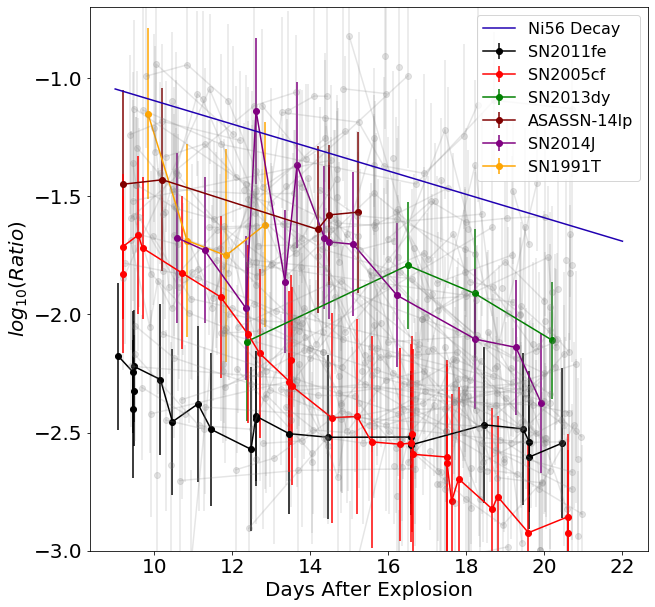

In [111]:
timeHigh=np.linspace(9,22,num=2000)
NiA,CoA,FeA=ChainCal(timeHigh)
for i in range(len(elemList)):
    xplot=timeList[i]
    yplot=elemList[i][:,28-1]
    yerrplot=errList[i][:,28-1]
    timeOrder=np.argsort(xplot)
    xplot=xplot[timeOrder]
    yplot=yplot[timeOrder]
    yerrplot=yerrplot[timeOrder]
    mask=(yplot<-0.6)&(yplot>-3.5)&(xplot<21)&(yerrplot<0.55)
    xplot=xplot[mask]
    yplot=yplot[mask]
    yerrplot=yerrplot[mask]
    if len(xplot)<1:continue
    if yplot[0]>-2.0:color='r'
    else:color='g'
    colorNum=dm15ChosL[i]
    colorNum=(colorNum-0.8)/(1.6-0.8)
    alp=0.2
    color='grey'#plt.cm.viridis(colorNum)
    mark='.'
    if snNameList[i]=='SN2011fe':
        color='k'
        alp=1
        mark='x'
    if snNameList[i]=='SN2005cf':
        color='r'
        alp=1
        mark='2'
    if snNameList[i]=='SN2013dy':
        color='g'
        alp=1
        mark='v'
    if snNameList[i]=='ASASSN-14lp':
        color='maroon'
        alp=1
        mark='d'
    if snNameList[i]=='SN2014J':
        color='purple'
        alp=1
        mark='*'
    if snNameList[i]=='SN1991T':
        color='orange'
        alp=1
        mark='4'
    
    
    plt.errorbar(xplot,yplot,yerr=yerrplot,c=color,alpha=alp,fmt='o-')
    
plt.plot(timeHigh,np.log10(NiA)-0.6,c='xkcd:ultramarine',zorder=10,label='Ni56 Decay')
plt.ylim(-3,-0.7)
plt.xlabel('Days After Explosion',fontsize=20)
plt.ylabel(r'$log_{10}(Ratio)$',fontsize=20)
plt.errorbar([],[],[],c='k',fmt='o-',label='SN2011fe')
plt.errorbar([],[],[],c='r',fmt='o-',label='SN2005cf')
plt.errorbar([],[],[],c='g',fmt='o-',label='SN2013dy')
plt.errorbar([],[],[],c='maroon',fmt='o-',label='ASASSN-14lp')
plt.errorbar([],[],[],c='purple',fmt='o-',label='SN2014J')
plt.errorbar([],[],[],c='orange',fmt='o-',label='SN1991T')

plt.legend(fontsize=16)
plt.tick_params(labelsize=20)
plt.gcf().set_size_inches(10,10)
#plt.savefig('plotout/paperPlot/NiCurve.png')

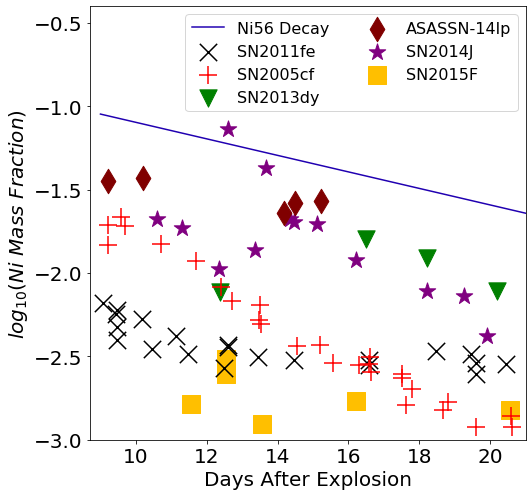

In [27]:
timeHigh=np.linspace(9,22,num=2000)
NiA,CoA,FeA=ChainCal(timeHigh)
for i in range(len(elemList)):
    xplot=timeList[i]
    yplot=elemList[i][:,28-1]
    yerrplot=errList[i][:,28-1]
    mask=(yplot<-0.6)&(yplot>-3.5)&(xplot<21)&(yerrplot<0.55)
    xplot=xplot[mask]
    yplot=yplot[mask]
    yerrplot=yerrplot[mask]
    if len(xplot)<1:continue
    if yplot[0]>-2.0:color='r'
    else:color='g'
    colorNum=dm15ChosL[i]
    colorNum=(colorNum-0.8)/(1.6-0.8)
    alp=0
    color='grey'#plt.cm.viridis(colorNum)
    mark='.'
    if snNameList[i]=='SN2011fe':
        color='k'
        alp=1
        mark='x'
    if snNameList[i]=='SN2005cf':
        color='r'
        alp=1
        mark='+'
    if snNameList[i]=='SN2013dy':
        color='g'
        alp=1
        mark='v'
    if snNameList[i]=='ASASSN-14lp':
        color='maroon'
        alp=1
        mark='d'
    if snNameList[i]=='SN2014J':
        color='purple'
        alp=1
        mark='*'
    if snNameList[i]=='SN2015F':
        color='#FFBF00'#Yamabuki color
        alp=1
        mark='s'
    
    plt.scatter(xplot,yplot,c=color,alpha=alp,marker=mark,s=300)
    
plt.plot(timeHigh,np.log10(NiA)-0.6,c='xkcd:ultramarine',zorder=10,label='Ni56 Decay')
plt.ylim(-3,-0.4)
plt.xlim(8.7,21)
plt.xlabel('Days After Explosion',fontsize=20)
plt.ylabel(r'$log_{10}(Ni\ Mass\ Fraction)$',fontsize=20)
plt.scatter([],[],c='k',label='SN2011fe',marker='x',s=300)
plt.scatter([],[],c='r',label='SN2005cf',marker='+',s=300)
plt.scatter([],[],c='g',label='SN2013dy',marker='v',s=300)
plt.scatter([],[],c='maroon',label='ASASSN-14lp',marker='d',s=300)
plt.scatter([],[],c='purple',label='SN2014J',marker='*',s=300)
plt.scatter([],[],c='#FFBF00',label='SN2015F',marker='s',s=300)

plt.legend(fontsize=16,ncol=2)
plt.tick_params(labelsize=20)
plt.gcf().set_size_inches(7.5,7)
plt.tight_layout()
plt.savefig('plotout/paperPlot/NiCurve.png')

In [21]:
np.where(np.array(snNameList)=='SN2014J')

(array([101]),)

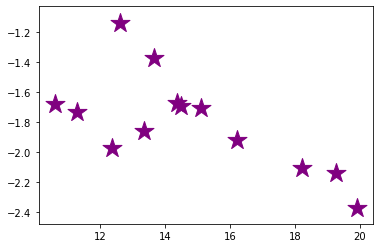

In [22]:
i=101
xplot=timeList[i]
yplot=elemList[i][:,28-1]
yerrplot=errList[i][:,28-1]
telplot=np.array(telNameLG[i])
mask=(yplot<-0.6)&(yplot>-3.5)&(xplot<21)&(yerrplot<0.55)
xplot=xplot[mask]
yplot=yplot[mask]
yerrplot=yerrplot[mask]
telplot=telplot[mask]
if yplot[0]>-2.0:color='r'
else:color='g'
colorNum=dm15ChosL[i]
colorNum=(colorNum-0.8)/(1.6-0.8)
alp=0
color='grey'#plt.cm.viridis(colorNum)
mark='.'
if snNameList[i]=='SN2011fe':
    color='k'
    alp=1
    mark='x'
if snNameList[i]=='SN2005cf':
    color='r'
    alp=1
    mark='2'
if snNameList[i]=='SN2013dy':
    color='g'
    alp=1
    mark='v'
if snNameList[i]=='ASASSN-14lp':
    color='maroon'
    alp=1
    mark='d'
if snNameList[i]=='SN2014J':
    color='purple'
    alp=1
    mark='*'
if snNameList[i]=='SN1991T':
    color='orange'
    alp=1
    mark='4'
plt.scatter(xplot,yplot,c=color,alpha=alp,marker=mark,s=400)

In [26]:
mask=(xplot<14)&(yplot<-1.8)
np.array(telplot)[mask]

array(['HCT-2m / HFOSC', 'HCT-2m / HFOSC'], dtype='<U15')

In [24]:
mask=(yplot>-1.5)
np.array(telplot)[mask],yplot[mask]

(array(['WHT-4.2m / ACAM', 'WHT-4.2m / ACAM'], dtype='<U15'),
 array([-1.1374319, -1.3688538], dtype=float32))

In [27]:
telplot

array(['WHT-4.2m / ACAM', 'HCT-2m / HFOSC', 'HCT-2m / HFOSC',
       'WHT-4.2m / ACAM', 'HCT-2m / HFOSC', 'WHT-4.2m / ACAM',
       'HCT-2m / HFOSC', 'WHT-4.2m / ACAM', 'HCT-2m / HFOSC',
       'HCT-2m / HFOSC', 'HCT-2m / HFOSC', 'HCT-2m / HFOSC',
       'HCT-2m / HFOSC'], dtype='<U15')

In [112]:
intMdl()

(9, 10)

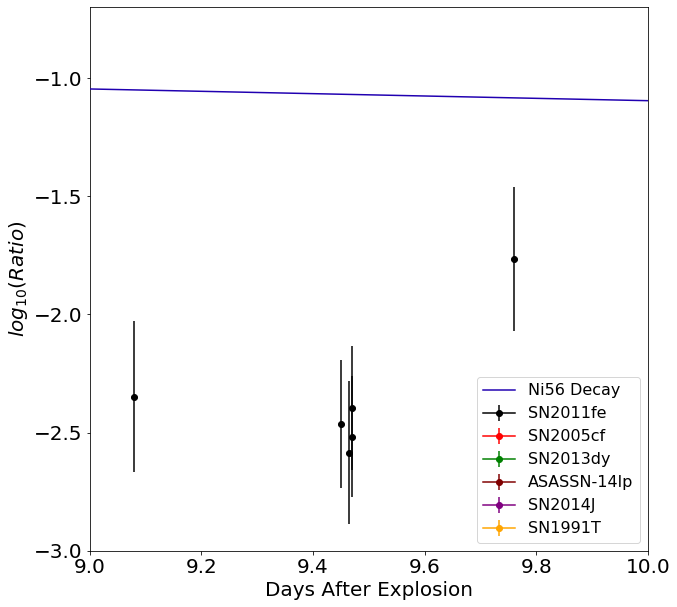

In [18]:
timeHigh=np.linspace(9,22,num=2000)
NiA,CoA,FeA=ChainCal(timeHigh)
for i in range(len(elemList)):
    xplot=timeList[i]
    yplot=elemList[i][:,28-1]
    yerrplot=errList[i][:,28-1]
    timeOrder=np.argsort(xplot)
    xplot=xplot[timeOrder]
    yplot=yplot[timeOrder]
    yerrplot=yerrplot[timeOrder]
    mask=(yplot<-0.6)&(yplot>-3.5)&(xplot<21)&(yerrplot<0.55)
    xplot=xplot[mask]
    yplot=yplot[mask]
    yerrplot=yerrplot[mask]
    if len(xplot)<1:continue
    if yplot[0]>-2.0:color='r'
    else:color='g'
    colorNum=dm15ChosL[i]
    colorNum=(colorNum-0.8)/(1.6-0.8)
    if snNameList[i]!='SN2011fe':continue
    alp=0.2
    color='grey'#plt.cm.viridis(colorNum)
    if snNameList[i]=='SN2011fe':
        color='k'
        alp=1
    if snNameList[i]=='SN2005cf':
        color='r'
        alp=1
    if snNameList[i]=='SN2013dy':
        color='g'
        alp=1
    if snNameList[i]=='ASASSN-14lp':
        color='maroon'
        alp=1
    if snNameList[i]=='SN2014J':
        color='purple'
        alp=1
    if snNameList[i]=='SN1991T':
        color='orange'
        alp=1
    
    plt.errorbar(xplot,yplot,yerr=yerrplot,c=color,alpha=alp,fmt='o')
    if snNameList[i]=='SN2011fe':break
    
plt.plot(timeHigh,np.log10(NiA)-0.6,c='xkcd:ultramarine',zorder=10,label='Ni56 Decay')
plt.ylim(-3,-0.7)
plt.xlabel('Days After Explosion',fontsize=20)
plt.ylabel(r'$log_{10}(Ratio)$',fontsize=20)
plt.errorbar([],[],[],c='k',fmt='o-',label='SN2011fe')
plt.errorbar([],[],[],c='r',fmt='o-',label='SN2005cf')
plt.errorbar([],[],[],c='g',fmt='o-',label='SN2013dy')
plt.errorbar([],[],[],c='maroon',fmt='o-',label='ASASSN-14lp')
plt.errorbar([],[],[],c='purple',fmt='o-',label='SN2014J')
plt.errorbar([],[],[],c='orange',fmt='o-',label='SN1991T')

plt.legend(fontsize=16)
plt.tick_params(labelsize=20)
plt.gcf().set_size_inches(10,10)
plt.xlim(9,10)

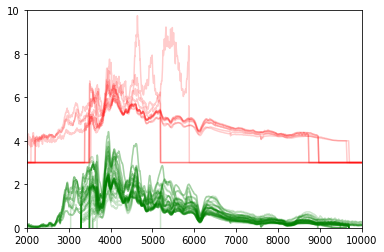

In [94]:
for j in range(len(XspecList[i])):
    if elemList[i][j,28-1]>=-2.2:
        plt.plot(wave,XspecList[i][j]+4,c='r',alpha=0.2)
    else:
        plt.plot(wave,XspecList[i][j],c='g',alpha=0.2)
    if t
plt.xlim(2000,10000)
plt.ylim(0,10)
plt.savefig('plotout/11feGoodBad.png',dpi=200)

In [87]:
elemList[i][1]

(30,)

In [76]:
def ChiSq(param,time=xplot,yobs=yplot,yerr=yerrplot):
    k=-1/6.075/np.log2(10)
    b=param[0]
    #b=param[1]
    ymdl=k*time+b
    return np.sum((yobs-ymdl)**2/yerr**2)

In [77]:
plt

<module 'matplotlib.pyplot' from '/scratch/user/chenxingzhuo/.conda/envs/keras/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [78]:
result=minimize(ChiSq,x0=[-1])
print(result)

      fun: 42.391318813943144
 hess_inv: array([[1]])
      jac: array([6.19888306e-06])
  message: 'Optimization terminated successfully.'
     nfev: 9
      nit: 1
     njev: 3
   status: 0
  success: True
        x: array([-1.34999415])


In [79]:
ChiSq(result.x),len(xplot)

(42.391318813943144, 35)

# $WeightedMean=\frac{\Sigma_i \frac{log_{10}(Ni)_i-a\times t_i}{\sigma_i^2}}{\Sigma_i \frac{1}{\sigma_i^2}}$  
# $error=\sqrt{1/\Sigma_i \frac{1}{\sigma_i^2}}$

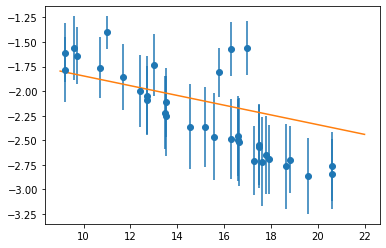

In [80]:
k=-1/6.075/np.log2(10)
b=result.x
plt.errorbar(xplot,yplot,yerr=yerrplot,fmt='o')
plt.plot(timeHigh,timeHigh*k+b)
plt.savefig('plotout/13dyNiCurveFit.png',dpi=200)

In [22]:
yout=[]
yerrout=[]
timeOut=[]
dm15out=[]
dm15errout=[]
typeList=[]
specList=[]
nameSelList=[]
timeMin=12
timeMax=15

for i in range(len(elemList)):
    timeCol=timeList[i]
    mask=(timeCol>timeMin)&(timeCol<=timeMax)
    timeCol=timeCol[mask]
    if len(timeCol)==0:continue
    timeOut.append(timeCol)
    yplot=elemList[i][mask,28-1]
    yerrplot=errList[i][mask,28-1]
    yout.append(yplot)
    dm15out.append(np.ones(len(yplot))*dm15ChosL[i])
    specList.append(XspecList[i][mask])
    typeList.append(dm15List[dm15List['ObjName']==snNameList[i]]['Subtype'].iloc[0])
    yerrout.append(yerrplot)
    dm15errout.append(np.ones(len(yplot))*dm15ErrL[i])
    nameSelList.append(snNameList[i])

218

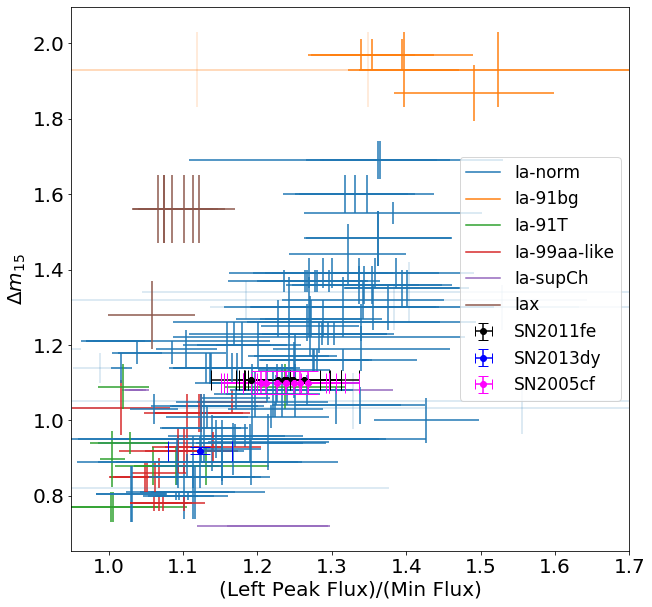

In [26]:
cList=['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','e377c2']
count=0
for i in range(len(yout)):
    yplot=dm15out[i]
    yerrplot=dm15errout[i]
    if typeList[i]=='Ia-norm':color=cList[0]
    if typeList[i]=='Ia-91bg':color=cList[1]
    if typeList[i]=='Ia-91T':color=cList[2]
    if typeList[i]=='Ia-99aa-like':color=cList[3]
    if typeList[i]=='Ia-supCh':color=cList[4]
    if typeList[i]=='Iax':color=cList[5]
    
    for phaseInd in range(len(specList[i])):
        flux=specList[i][phaseInd].flatten()
        minFlux,minWave,leftMaxFlux,leftMaxWave,rightMaxFlux,rightMaxWave,leftWidth,rightWidth=MinMaxSpec(flux)
        if flux[np.argwhere(wave==leftWidth+minWave)[0,0]+1]<0:continue
        minWaveInd=np.argwhere(wave==minWave).flatten()[0]
        minSNR=minFlux/np.std(flux[minWaveInd-10:minWaveInd+10])
        
        leftMaxInd=np.argwhere(wave==leftMaxWave).flatten()[0]
        leftSNR=leftMaxFlux/np.std(flux[leftMaxInd-10:leftMaxInd+10])
        xerrplotOne=leftMaxFlux/minFlux*(1/minSNR**2+1/leftSNR**2)**0.5
        xplotOne=leftMaxFlux/minFlux
        alp=1
        if xerrplotOne>0.2 or yerrplot[phaseInd]>0.35 or xplotOne<1:alp=0.2
        if xplotOne>1.7:continue
        fmtDef=''
        capper=None
        if nameSelList[i]=='SN2011fe':
            color='k'
            alp=1
            fmtDef='8'
            capper=10
        if nameSelList[i]=='SN2013dy':
            color='b'
            alp=1
            fmtDef='8'
            capper=10
        if nameSelList[i]=='SN2005cf':
            color='magenta'
            alp=1
            fmtDef='8'
            capper=10
        
        plt.errorbar([xplotOne],[yplot[phaseInd]],yerr=[yerrplot[phaseInd]],xerr=[xerrplotOne],alpha=alp,c=color,fmt=fmtDef,capsize=capper)
        count=count+1
plt.gcf().set_size_inches(10,10)
plt.xlim(0.95,1.7)
#plt.ylim(-3.5,0)
plt.ylabel(r'$\Delta m_{15}$',fontsize=20)
plt.xlabel('(Left Peak Flux)/(Min Flux)',fontsize=20)

plt.errorbar([],[],[],[],c='k',fmt='o',label='SN2011fe',capsize=5)
plt.errorbar([],[],[],[],c='b',fmt='o',label='SN2013dy',capsize=5)
plt.errorbar([],[],[],[],c='magenta',fmt='o',label='SN2005cf',capsize=5)
plt.plot([],[],c=cList[0],label='Ia-norm')
plt.plot([],[],c=cList[1],label='Ia-91bg')
plt.plot([],[],c=cList[2],label='Ia-91T')
plt.plot([],[],c=cList[3],label='Ia-99aa-like')
plt.plot([],[],c=cList[4],label='Ia-supCh')
plt.plot([],[],c=cList[5],label='Iax')
plt.legend(fontsize=17)
plt.tick_params(labelsize=20)
#plt.savefig('plotout/paperPlot/FluxRatioNi3Phase1.png')
count

In [242]:
xplot[np.argsort(xplot)]

array([14.78408927, 14.79689416, 19.70496399, 27.5       , 27.74310288,
       27.7615961 , 36.5       , 36.66051976, 36.69133635])

SN2006or


40

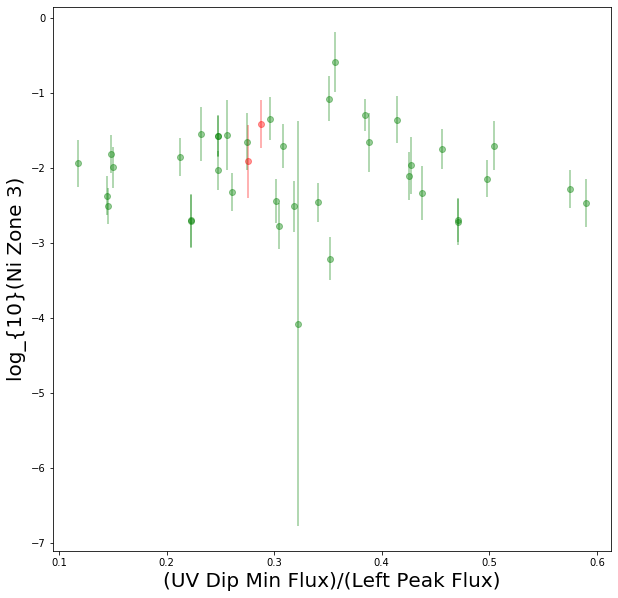

In [205]:
count=0
for i in range(len(yout)):
    yplot=yout[i]
    yerrplot=yerrout[i]
    if typeList[i]!='Ia-norm':
        color='r'
    else:color='g'
    for phaseInd in range(len(specList[i])):
        flux=specList[i][phaseInd].flatten()
        minFlux,minWave,leftMaxFlux,leftMaxWave,rightMaxFlux,rightMaxWave,leftWidth,rightWidth=MinMaxSpec(flux)
        if flux[np.argwhere(wave==leftWidth+minWave)[0,0]+1]<0:continue
        
        uvSpecSma=np.array([wave,flux]).T
        uvSpecSma=uvSpecSma[uvSpecSma[:,0]<3500]
        uvSpecSma=uvSpecSma[uvSpecSma[:,0]>3180]
        uvFluxMin=np.min(uvSpecSma[:,1])
        uvWaveMin=uvSpecSma[:,0][np.argmin(uvSpecSma[:,1])]
        if uvFluxMin<0:continue
        plt.errorbar([uvFluxMin/leftMaxFlux],[yplot[phaseInd]],yerr=[yerrplot[phaseInd]],alpha=0.4,c=color,fmt='o')
        if uvFluxMin/leftMaxFlux<0.2 and yplot[phaseInd]<-2.5:
            print(nameSelList[i])
            #plt.plot(wave,flux)
            #plt.scatter([uvWaveMin],[uvFluxMin],c='k')
        count=count+1
#plt.xlim(0,1.1)
#plt.ylim(-4,0)
plt.gcf().set_size_inches(10,10)
plt.ylabel(r'log_{10}(Ni Zone 3)',fontsize=20)
plt.xlabel('(UV Dip Min Flux)/(Left Peak Flux)',fontsize=20)
plt.savefig('plotout/Ni_UVMinDivLeftMax.png')
count

239

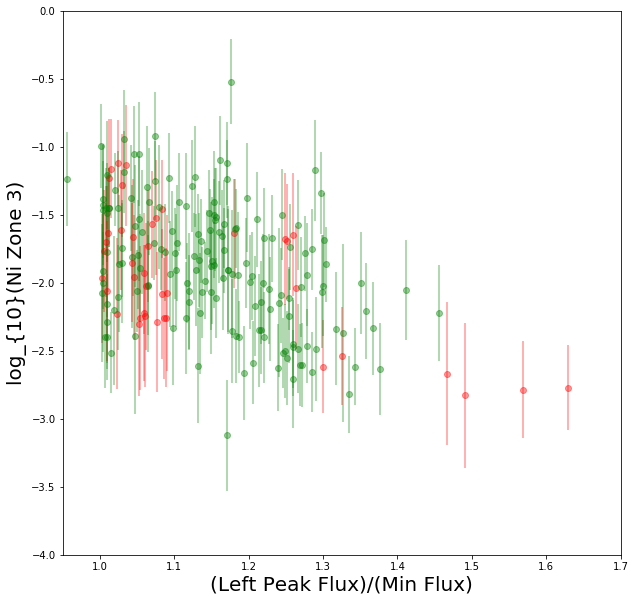

In [125]:
count=0
for i in range(len(yout)):
    yplot=yout[i]
    yerrplot=yerrout[i]
    if typeList[i]!='Ia-norm':
        color='r'
    else:color='g'
    for phaseInd in range(len(specList[i])):
        flux=specList[i][phaseInd].flatten()
        minFlux,minWave,leftMaxFlux,leftMaxWave,rightMaxFlux,rightMaxWave,leftWidth,rightWidth=MinMaxSpec(flux)
        if flux[np.argwhere(wave==leftWidth+minWave)[0,0]+1]<0:continue
        
        plt.errorbar([leftMaxFlux/minFlux],[yplot[phaseInd]],yerr=[yerrplot[phaseInd]],alpha=0.4,c=color,fmt='o')
        if uvFluxMin/leftMaxFlux<0.2 and yplot[phaseInd]<-2.5:
            print(nameSelList[i])
        count=count+1
plt.gcf().set_size_inches(10,10)
plt.xlim(0.95,1.7)
plt.ylim(-4,0)
plt.ylabel(r'log_{10}(Ni Zone 3)',fontsize=20)
plt.xlabel('(Left Peak Flux)/(Min Flux)',fontsize=20)
plt.savefig('plotout/Ni_LeftMaxDivMin.png')
count

162

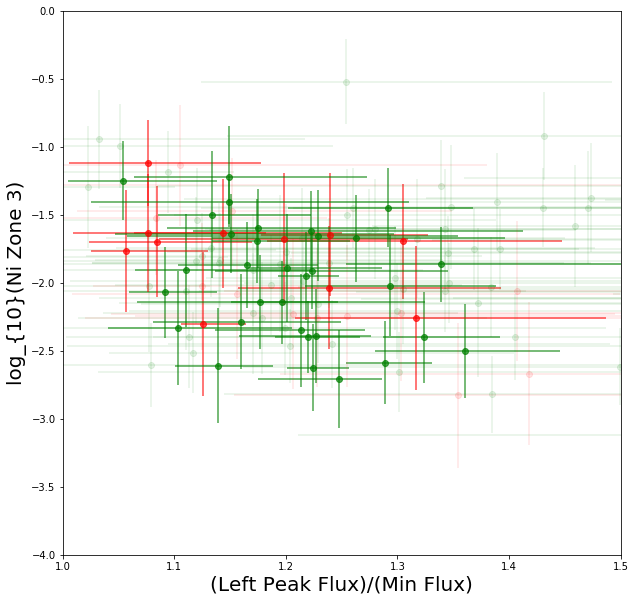

In [89]:
count=0
for i in range(len(yout)):
    yplot=yout[i]
    yerrplot=yerrout[i]
    if typeList[i]!='Ia-norm':
        color='r'
    else:color='g'
    try:
        FluxSampSeq=np.load('../SpecLineError/SpecSampSave/'+nameSelList[i]+'/FluxListSeq.npy',allow_pickle=True)
        WaveSampSeq=np.load('../SpecLineError/SpecSampSave/'+nameSelList[i]+'/WaveListSeq.npy',allow_pickle=True)
    except:continue
    for phaseInd in range(len(specList[i])):
        flux=specList[i][phaseInd].flatten()
        FluxSampList=FluxSampSeq[phaseInd]
        WaveSampList=WaveSampSeq[phaseInd]
        #mask=(FluxSampList[:,4]>0)&((WaveSampList[:,4]-np.nanmedian(WaveSampList[:,4]))**2<0.1)
        #FluxSampList=FluxSampList[mask]
        xsample=FluxSampList[:,4]/FluxSampList[:,5]
        xsample=xsample[np.isnan(xsample)==False]
        if len(xsample)==0:continue
        xlow=np.quantile(xsample,0.16)
        xmid=np.quantile(xsample,0.5)
        if xmid==1:continue
        xupp=np.quantile(xsample,0.84)
        if xupp-xlow<0.3:alp=0.7
        else:alp=0.1
        plt.errorbar([xmid],[yplot[phaseInd]],yerr=[yerrplot[phaseInd]],xerr=[[xmid-xlow],[xupp-xmid]],alpha=alp,c=color,fmt='o')
        if uvFluxMin/leftMaxFlux<0.2 and yplot[phaseInd]<-2.5:
            print(nameSelList[i])
        count=count+1
plt.gcf().set_size_inches(10,10)
plt.xlim(1,1.5)
plt.ylim(-4,0)
plt.ylabel(r'log_{10}(Ni Zone 3)',fontsize=20)
plt.xlabel('(Left Peak Flux)/(Min Flux)',fontsize=20)
#plt.savefig('plotout/Ni_LeftMaxDivMin.png')
count

4003.2025620496397 3971.405877680699
4032.258064516129 3984.06374501992


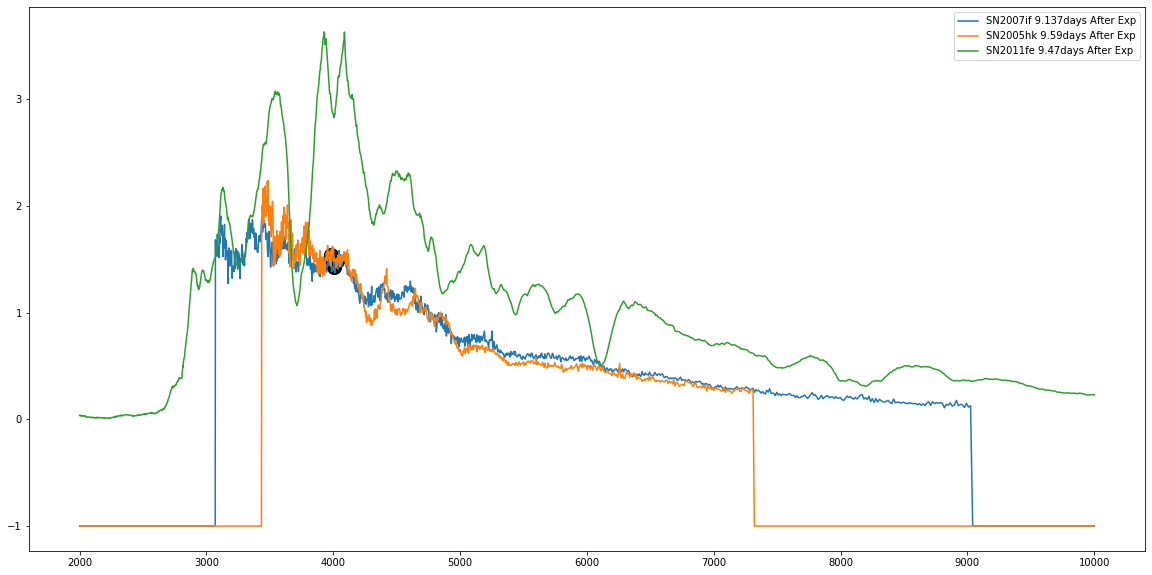

In [222]:
count=0
for i in range(len(yout)):
    yplot=yout[i]
    yerrplot=yerrout[i]
    if typeList[i]!='Ia-norm':
        color='r'
    else:color='g'
    for phaseInd in range(len(specList[i])):
        flux=specList[i][phaseInd].flatten()
        minFlux,minWave,leftMaxFlux,leftMaxWave,rightMaxFlux,rightMaxWave,leftWidth,rightWidth=MinMaxSpec(flux)
        if flux[np.argwhere(wave==leftWidth+minWave)[0,0]+1]<0:continue
        minWaveInd=np.argwhere(wave==minWave).flatten()[0]
        minSNR=minFlux/np.std(flux[minWaveInd-10:minWaveInd+10])
        
        leftMaxInd=np.argwhere(wave==leftMaxWave).flatten()[0]
        leftSNR=leftMaxFlux/np.std(flux[leftMaxInd-10:leftMaxInd+10])
        xerrplotOne=leftMaxFlux/minFlux*(1/minSNR**2+1/leftSNR**2)**0.5
        xplotOne=leftMaxFlux/minFlux
        if xplotOne<1.05 and yplot[phaseInd]<-2.3:
            plt.plot(wave,specList[i][phaseInd],label=nameSelList[i]+' '+str(round(timeOut[i][phaseInd],3))+'days After Exp')
            plt.scatter([minWave,leftMaxWave],[minFlux,leftMaxFlux],c='k',s=200)
            print(minWave,leftMaxWave)
        count=count+1
count
i=18
phaseInd=11
plt.plot(wave,specList[i][phaseInd],label=nameSelList[i]+' '+str(round(timeOut[i][phaseInd],3))+'days After Exp')
plt.gcf().set_size_inches(20,10)
plt.legend()
#plt.savefig('plotout/OutLiers.png',dpi=200)

In [102]:
cenPix=1500
sig=np.median(flux[cenPix-10:cenPix+10])
nor=np.std(flux[cenPix-10:cenPix+10])
print(sig,nor,sig/nor)
cenPix=1000
sig=np.median(flux[cenPix-10:cenPix+10])
nor=np.std(flux[cenPix-10:cenPix+10])
print(sig,nor,sig/nor)
cenPix=1200
sig=np.median(flux[cenPix-10:cenPix+10])
nor=np.std(flux[cenPix-10:cenPix+10])
print(sig,nor,sig/nor)


0.25077282732834805 0.03487402096066877 7.190820571312148
1.9439314020809997 0.08748041909976327 22.22133160866693
0.952577148493299 0.033052318437073465 28.82028231413961


In [87]:
yout=[]
yerrout=[]
timeOut=[]
xout=[]
xerrout=[]
typeList=[]

timeMin=21
timeMax=24

for i in range(len(elemList)):
    timeCol=timeList[i]
    mask=(timeCol>timeMin)&(timeCol<=timeMax)
    timeCol=timeCol[mask]
    if len(timeCol)==0:continue
    timeOut.append(timeCol)
    yplot=elemList[i][mask,28-1]
    yerrplot=errList[i][mask,28-1]
    yout.append(yplot)
    xout.append(np.ones(len(yplot))*dm15ChosL[i])
    
    typeList.append(dm15List[dm15List['ObjName']==snNameList[i]]['Subtype'].iloc[0])
    yerrout.append(yerrplot)
    xerrout.append(np.ones(len(yplot))*dm15ErrL[i])
    

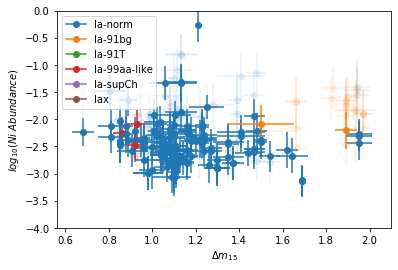

In [88]:
cList=['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','e377c2']
for i in range(len(timeOut)):
    if typeList[i]=='Ia-norm':color=cList[0]
    if typeList[i]=='Ia-91bg':color=cList[1]
    if typeList[i]=='Ia-91T':color=cList[2]
    if typeList[i]=='Ia-99aa-like':color=cList[3]
    if typeList[i]=='Ia-supCh':color=cList[4]
    if typeList[i]=='Iax':color=cList[5]
    xplot=xout[i]
    yplot=yout[i]
    xerrplot=xerrout[i]
    yerrplot=yerrout[i]
    
    mask=(yerrplot<0.35)
    plt.errorbar(xplot[mask],yplot[mask],yerr=yerrplot[mask],xerr=xerrplot[mask],fmt='o',c=color,alpha=1)
    mask=(mask==False)
    plt.errorbar(xplot[mask],yplot[mask],yerr=yerrplot[mask],xerr=xerrplot[mask],fmt='o',c=color,alpha=0.1)
plt.ylim(-4,0)

plt.plot([],[],marker='o',label='Ia-norm',color=cList[0])
plt.plot([],[],marker='o',label='Ia-91bg',color=cList[1])
plt.plot([],[],marker='o',label='Ia-91T',color=cList[2])
plt.plot([],[],marker='o',label='Ia-99aa-like',color=cList[3])
plt.plot([],[],marker='o',label='Ia-supCh',color=cList[4])
plt.plot([],[],marker='o',label='Iax',color=cList[5])
plt.legend()
#plt.title('Phase: -3 days to 0 days')
plt.xlabel(r'$\Delta m_{15}$')
plt.ylabel(r'$log_{10}(Ni\ Abundance)$')
plt.savefig('plotout/paperPlot/dm15Ni3Phase5.png',dpi=200)

In [99]:
Ni56H=6.075
yout=[]
yerrout=[]
timeOut=[]
xout=[]
xerrout=[]
typeList=[]

timeMin=5
timeMax=12

for i in range(len(elemList)):
    timeFirst=timeList[i][0]
    if timeFirst>15:continue
    timeOut.append(timeFirst)
    yplot=elemList[i][0,28-1]
    #yplot=yplot*2**((timeFirst-10)/Ni56H)
    yerrplot=errList[i][0,28-1]
    typeList.append(dm15List[dm15List['ObjName']==snNameList[i]]['Subtype'].iloc[0])
    if yplot>-0.7:
        print(i)
        print(snNameList[i])
        print(dm15List[dm15List['ObjName']==snNameList[i]]['Subtype'].iloc[0])
    #if yerrplot>0.4:continue
    
    xout.append(dm15ChosL[i])
    xerrout.append(dm15ErrL[i])
    yout.append(yplot)
    yerrout.append(yerrplot)
typeList=np.array(typeList)
xout=np.array(xout)
yout=np.array(yout)
xerrout=np.array(xerrout)
yerrout=np.array(yerrout)

145
SN2006lf
Ia-norm


In [85]:
yout=[]
yerrout=[]
timeOut=[]
xout=[]
xerrout=[]
typeList=[]

timeMin=18
timeMax=21

for i in range(len(elemList)):
    timeCol=timeList[i]
    mask=(timeCol>timeMin)&(timeCol<=timeMax)
    timeCol=timeCol[mask]
    if len(timeCol)==0:continue
    timeOut.append(timeCol)
    yplot=elemList[i][mask,28-1]
    yerrplot=errList[i][mask,28-1]
    yout.append(yplot)
    xout.append(np.ones(len(yplot))*dm15ChosL[i])
    
    typeList.append(dm15List[dm15List['ObjName']==snNameList[i]]['Subtype'].iloc[0])
    yerrout.append(yerrplot)
    xerrout.append(np.ones(len(yplot))*dm15ErrL[i])
    

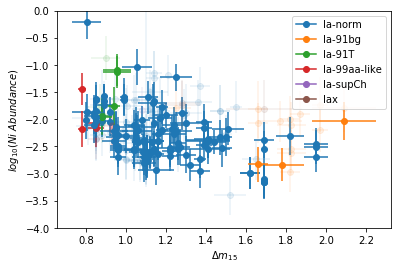

In [86]:
cList=['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','e377c2']
for i in range(len(timeOut)):
    if typeList[i]=='Ia-norm':color=cList[0]
    if typeList[i]=='Ia-91bg':color=cList[1]
    if typeList[i]=='Ia-91T':color=cList[2]
    if typeList[i]=='Ia-99aa-like':color=cList[3]
    if typeList[i]=='Ia-supCh':color=cList[4]
    if typeList[i]=='Iax':color=cList[5]
    xplot=xout[i]
    yplot=yout[i]
    xerrplot=xerrout[i]
    yerrplot=yerrout[i]
    
    mask=(yerrplot<0.35)
    plt.errorbar(xplot[mask],yplot[mask],yerr=yerrplot[mask],xerr=xerrplot[mask],fmt='o',c=color,alpha=1)
    mask=(mask==False)
    plt.errorbar(xplot[mask],yplot[mask],yerr=yerrplot[mask],xerr=xerrplot[mask],fmt='o',c=color,alpha=0.1)
plt.ylim(-4,0)

plt.plot([],[],marker='o',label='Ia-norm',color=cList[0])
plt.plot([],[],marker='o',label='Ia-91bg',color=cList[1])
plt.plot([],[],marker='o',label='Ia-91T',color=cList[2])
plt.plot([],[],marker='o',label='Ia-99aa-like',color=cList[3])
plt.plot([],[],marker='o',label='Ia-supCh',color=cList[4])
plt.plot([],[],marker='o',label='Iax',color=cList[5])
plt.legend()
#plt.title('Phase: -3 days to 0 days')
plt.xlabel(r'$\Delta m_{15}$')
plt.ylabel(r'$log_{10}(Ni\ Abundance)$')
plt.savefig('plotout/paperPlot/dm15Ni3Phase4.png',dpi=200)

Text(0.5, 1.0, 'Ni Zone 3')

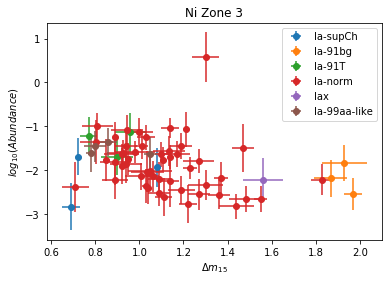

In [77]:
for typeOne in list(set(typeList)):
    mask=(typeList==typeOne)
    plt.errorbar(xout[mask],yout[mask],yerr=yerrout[mask],xerr=xerrout[mask],fmt='o',label=typeOne)
plt.legend()

#plt.ylim(-4,0.5)
plt.xlabel(r'$\Delta m_{15}$')
plt.ylabel(r'$log_{10}(Abundance)$')
plt.title('Ni Zone 3')
#plt.savefig('plotout/LeiCurve/DMcurveNi3.png',dpi=200)

In [172]:
typeOne='Ia-norm'
mask=(typeList==typeOne)
len(xout[mask])

2

In [25]:
yout[mask]

array([-0.9913954 , -2.0326734 , -2.3343074 , -2.3881717 , -2.3962388 ,
               nan, -1.2354177 , -1.8542004 , -1.068163  , -1.7648125 ,
       -1.9054129 , -2.8180838 , -2.5546298 , -1.492362  , -2.4487953 ,
       -1.4484708 , -1.045994  ,         nan, -2.6537383 , -1.3488168 ,
       -1.744476  , -1.805584  ,         nan,  0.57571936, -2.141388  ,
       -2.1693585 , -2.5115242 ,         nan, -1.5566621 , -2.764002  ,
       -2.2136955 , -1.5975745 , -1.1203344 ,         nan, -1.6370555 ,
       -1.7689874 ,         nan, -1.944462  , -1.61994   , -2.551837  ,
       -2.6087825 , -1.5795147 , -1.4461342 , -2.1911967 , -2.0145688 ,
       -2.218193  , -1.7051635 , -1.4533296 , -2.2447603 , -1.7823876 ,
       -2.6570177 ,         nan, -2.3634977 , -2.1382875 , -1.0936747 ,
       -1.2458084 , -1.6383858 ], dtype=float32)

In [16]:
len(X_train)/5+len(X_test)/5

108389.0

In [19]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 2000, 1)      0                                            
__________________________________________________________________________________________________
conv1d_109 (Conv1D)             (None, 1000, 8)      128         input_13[0][0]                   
__________________________________________________________________________________________________
conv1d_110 (Conv1D)             (None, 1000, 16)     400         conv1d_109[0][0]                 
__________________________________________________________________________________________________
batch_normalization_61 (BatchNo (None, 1000, 16)     64          conv1d_110[0][0]                 
__________________________________________________________________________________________________
activation

In [ ]:
DER